# P7 / Implémentez un modèle de scoring

## Introduction au projet

Je suis Data Scientist au sein d'une **société financière**, nommée "Prêt à dépenser",  qui propose des **crédits à la consommation** pour des personnes ayant peu ou pas du tout d'historique de prêt.

<img src=https://user.oc-static.com/upload/2019/02/25/15510866018677_logo%20projet%20fintech.png>

## Objectifs à atteindre / Mission

Les **objectifs** à atteindre dans le cadre de ce projet centré sur le domaine bancaire de la datascience sont nombreux.

1. Mettre en œuvre un outil de **“scoring crédit”** pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc **développer un algorithme de classification** en s’appuyant sur des sources de données variées.

2. Être totalement **transparent** vis-à-vis des décisions d’octroi de crédit en développant notament un **dashboard interactif** pour que les chargés de relation client puissent expliquer leurs décisions.

Ma **mission** dans ce cadre bien précis sera de :
* Construire un **modèle de scoring** qui donnera une prédiction sur la **probabilité de faillite d'un client** de façon automatique.
* Construire un **dashboard interactif** à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

Dans ce notebook, je m'occuperai de la partie préparation, nettoyage des données et aussi de la partie modélisation. J'utiliserai un **kaggle kernel pour faciliter la préparation des données** (comme cela est conseillé).

J'ai décidé de passer un peu plus de temps sur la partie nettoyage, filtrage et imputation des données issues du kaggle kernel puisque je me baserai **UNIQUEMENT sur les données transformées** pour les étapes suivantes de modélisation et visualisation via le tableau de bord interactif.

# Importation des modules nécessaires

In [1]:
from functions import *
import pandas as pd
print("pandas==",pd.__version__, sep='')
import numpy as np
print("numpy==",np.__version__, sep='')
import seaborn as sns
print("seaborn==",sns.__version__, sep='')
import scipy
import scipy.stats as scipy_stats
print("scipy==",scipy.__version__, sep='')
import pickle
import gc
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.utils.extmath import softmax
print("scikit-learn==",sklearn.__version__, sep='')
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm.callback import log_evaluation, early_stopping
print("lightgbm==",lightgbm.__version__, sep='')
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
print("imbalanced-learn==",imblearn.__version__, sep='')

pandas==1.3.4
numpy==1.21.0
seaborn==0.11.2
scipy==1.9.1
scikit-learn==1.1.1
lightgbm==3.3.2
imbalanced-learn==0.9.1


In [2]:
# Ces deux petites fonctions me serviront à exporter/charger toute sorte d'objets (dataframes, modèles, explainers...)

def save(obj, filename, filepath='.'):
    with open(f'{filepath}/{filename}.pickle', 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def load(filename, filepath='.'):
    with open(f'{filepath}/{filename}.pickle', 'rb') as f:
        return pickle.load(f)

# 1. Pré-traitement du Kernel Kaggle

Ici, j'utilise des fonctions du kaggle kernel que j'ai choisi afin de pré-traiter les données et les transformer. A l'issue de cette transformation, je ne travaillerai plus qu'avec des **données numériques** (les donnes catégorielles auront déjà été transformées).

In [3]:
debug = False

num_rows = 10000 if debug else None
df = application_train(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 13s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 13s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 26)
Process installments payments - done in 19s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s


# 2. Nettoyage et filtrage des données pré-traitées

In [4]:
data = df.copy()
print(data.shape)

(307507, 798)


Ici, je vais remplacer les valeurs `infinite` par `nan` pour pouvoir les filtrer plus facilement par la suite.

In [5]:
mask = pd.DataFrame(np.isfinite(data.values),
                    index=data.index,
                    columns=data.columns).replace({False: np.nan})
data = data.mul(mask)
data = data.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)

In [6]:
data = data.reset_index().drop(['level_0', 'index'], axis=1)

J'ai choisi de **supprimer les colonnes avec plus de 50% de valeurs manquantes** puisque leur imputation donnera probablement des résultat trop mauvais. **237 colonnes** sont supprimées lors de cette étape ! 

In [7]:
data = data.T[data.isna().mean() <= 0.5].T
print(data.shape)

(307507, 561)


J'ai utilisé la stratégie suivante pour **imputer les données manquantes** restantes pour chaque colonne.

Je vais calculer pour chaque colonne le **pourcentage des données remplies** et le **nombre de valeurs uniques**.

Si les données sont remplies à *plus de 90%* alors je considère avoir une *bonne représentativité dans les données*. Ainsi, s'il y a *moins de 30 valeurs uniques*, j'imputerai les données manquantes par la *valeur la plus fréquente*. Sinon, j'imputerai par la *médiane des valeurs présentes*.

Si les données sont remplies à *90% ou moins* alors je considère *ne pas avoir une bonne représentativité dans les données*. Ainsi, s'il y a *moins de 30 valeurs uniques*, j'imputerai les données manquantes par la *valeur médiane*. Sinon, j'imputerai par la *moyenne des valeurs présentes*.

In [8]:
missing_values_data = {}
for c in data.columns:
    missing_values_data[c] = {'percent_filled': 1 - data[c].isna().mean(),
                              'unique_values': len(data[c].unique())}
    
for c in data.columns:
    if missing_values_data[c]['percent_filled'] > 0.9:
        if missing_values_data[c]['unique_values'] > 30:
            data[c] = data[c].fillna(data[c].median())
        else:
            data[c] = data[c].fillna(data[c].mode())
    else:
        if missing_values_data[c]['unique_values'] > 30:
            data[c] = data[c].fillna(data[c].mean())
        else:
            data[c] = data[c].fillna(data[c].median())

J'ai également **supprimé quelques colonnes inutiles** en fonction de leur description et j'ai retiré les colonnes qui ne contiennent que **une seule valeur unique**. **41 colonnes** sont supprimées lors de cette étape ! 

In [9]:
useless_cols = ['WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY',
                'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
                'WEEKDAY_APPR_PROCESS_START_WEDNESDAY','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
                'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5',
                'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_18',
                'HOUR_APPR_PROCESS_START', 'REGION_RATING_CLIENT']

data = data[[c for c in data.columns if c not in useless_cols]]

for c in data.columns: 
    if (data[c].mean() == data[c].max()):
        data = data.drop(c, axis=1)
print(data.shape)

(307507, 520)


J'ai choisi de **supprimer une partie des colonnes qui sont trop corrélées entre elles** grâce à une évaluation de la corrélation de Pearson (coeff > 0.9) entre les features qui auront été **préalablement normalisées** et pour lesquelles j'aurai **enlevé les outliers**. 

Durant cette étape, je considère qu'une modalité sera un outlier si elle est éloignée d'**au moins 3 fois l'écart-type par rapport à la moyenne**.

In [10]:
outlier_threshold = 3
minmax = MinMaxScaler()

data_normalized_without_outliers = pd.DataFrame()
for c in data.columns:
    if c != 'TARGET' and missing_values_data[c]['unique_values'] > 30:
        mask_outliers = (data[c] >= (data[c].mean() - outlier_threshold * data[c].std())) & (data[c] <= (data[c].mean() + outlier_threshold * data[c].std()))
        s = pd.Series(minmax.fit_transform(data[c].loc[mask_outliers].to_frame()).reshape(-1), index=data[c].loc[mask_outliers].index, name=c)
        data_normalized_without_outliers = pd.concat([data_normalized_without_outliers, s], axis=1)

mask = data_normalized_without_outliers.isna().any(1)
data_normalized_without_outliers = data_normalized_without_outliers.loc[mask]

In [11]:
corr = data_normalized_without_outliers.corr()

In [12]:
for pearson_threshold in [0.8, 0.9, 0.95, 0.99]:
    corr_features = corr[((np.abs(corr) > pearson_threshold) & (np.abs(corr) < 1)).any(1)].index
    print(f'# {len(corr_features)} colonnes avec corrélation de Pearson = {pearson_threshold}')

# 161 colonnes avec corrélation de Pearson = 0.8
# 97 colonnes avec corrélation de Pearson = 0.9
# 55 colonnes avec corrélation de Pearson = 0.95
# 18 colonnes avec corrélation de Pearson = 0.99


In [13]:
columns_dropped = []
    
for c1 in corr.columns:
    s = np.abs(corr[c1]).sort_values()
    c2 = s[(s > 0.9) & (s != 1)].index.tolist()
    if c2 and c1 not in columns_dropped:
        for i, c in enumerate(c2):
            if c not in columns_dropped:
                columns_dropped.append(c2[i])
                data = data.drop(c2[i],axis=1)

In [14]:
print(data.shape)

(307507, 467)


J'ai choisi de récupérer ici les **meilleures features déterminées à l'aide d'un Classifier LGBM optimisé** (celui utilisé dans le  kaggle kernel que j'ai choisi au départ).

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[1]	valid_0's auc: 0.724601	valid_0's binary_logloss: 0.662095	valid_1's auc: 0.713489	valid_1's binary_logloss: 0.664534
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.725355	valid_0's binary_logloss: 0.65927	valid_1's auc: 0.714277	valid_1's binary_logloss: 0.661854
[3]	valid_0's auc: 0.730422	valid_0's binary_logloss: 0.656564	valid_1's auc: 0.719232	valid_1's binary_logloss: 0.659284
[4]	valid_0's auc: 0.729988	valid_0's binary_logloss: 0.653952	valid_1's auc: 0.718619	valid_1's binary_logloss: 0.656837
[5]	valid_0's auc: 0.733792	valid_0's binary_logloss: 0.651431	valid_1's auc: 0.722148	valid_1's binary_logloss: 0.654478
[6]	valid_0's auc: 0.734635	valid_0's binary_logloss: 0.649011	valid_1's auc: 0.722641	valid_1's binary_logloss: 0.652226
[7]	valid_0's auc: 0.739021	valid_0's binary_logloss: 0.64702	valid_1's auc: 0.725794	valid_1'

[68]	valid_0's auc: 0.763704	valid_0's binary_logloss: 0.578085	valid_1's auc: 0.743049	valid_1's binary_logloss: 0.5904
[69]	valid_0's auc: 0.764139	valid_0's binary_logloss: 0.577482	valid_1's auc: 0.743369	valid_1's binary_logloss: 0.589939
[70]	valid_0's auc: 0.764523	valid_0's binary_logloss: 0.576908	valid_1's auc: 0.743615	valid_1's binary_logloss: 0.5895
[71]	valid_0's auc: 0.764866	valid_0's binary_logloss: 0.576352	valid_1's auc: 0.743794	valid_1's binary_logloss: 0.589106
[72]	valid_0's auc: 0.765339	valid_0's binary_logloss: 0.575752	valid_1's auc: 0.744131	valid_1's binary_logloss: 0.588636
[73]	valid_0's auc: 0.765768	valid_0's binary_logloss: 0.575217	valid_1's auc: 0.74438	valid_1's binary_logloss: 0.588264
[74]	valid_0's auc: 0.766138	valid_0's binary_logloss: 0.574676	valid_1's auc: 0.744624	valid_1's binary_logloss: 0.587863
[75]	valid_0's auc: 0.766615	valid_0's binary_logloss: 0.574126	valid_1's auc: 0.745002	valid_1's binary_logloss: 0.587432
[76]	valid_0's auc: 0

[139]	valid_0's auc: 0.788573	valid_0's binary_logloss: 0.547413	valid_1's auc: 0.758871	valid_1's binary_logloss: 0.569369
[140]	valid_0's auc: 0.788903	valid_0's binary_logloss: 0.547042	valid_1's auc: 0.75914	valid_1's binary_logloss: 0.569097
[141]	valid_0's auc: 0.789193	valid_0's binary_logloss: 0.546726	valid_1's auc: 0.759242	valid_1's binary_logloss: 0.568945
[142]	valid_0's auc: 0.78948	valid_0's binary_logloss: 0.546413	valid_1's auc: 0.759454	valid_1's binary_logloss: 0.568739
[143]	valid_0's auc: 0.789711	valid_0's binary_logloss: 0.546116	valid_1's auc: 0.759597	valid_1's binary_logloss: 0.568569
[144]	valid_0's auc: 0.790024	valid_0's binary_logloss: 0.545794	valid_1's auc: 0.759751	valid_1's binary_logloss: 0.568395
[145]	valid_0's auc: 0.790287	valid_0's binary_logloss: 0.545489	valid_1's auc: 0.759932	valid_1's binary_logloss: 0.568205
[146]	valid_0's auc: 0.790578	valid_0's binary_logloss: 0.545147	valid_1's auc: 0.760173	valid_1's binary_logloss: 0.567953
[147]	vali

[217]	valid_0's auc: 0.806328	valid_0's binary_logloss: 0.527051	valid_1's auc: 0.768192	valid_1's binary_logloss: 0.558632
[218]	valid_0's auc: 0.806541	valid_0's binary_logloss: 0.526818	valid_1's auc: 0.76834	valid_1's binary_logloss: 0.558495
[219]	valid_0's auc: 0.806744	valid_0's binary_logloss: 0.526607	valid_1's auc: 0.768398	valid_1's binary_logloss: 0.558423
[220]	valid_0's auc: 0.806885	valid_0's binary_logloss: 0.526401	valid_1's auc: 0.768448	valid_1's binary_logloss: 0.558335
[221]	valid_0's auc: 0.807046	valid_0's binary_logloss: 0.526206	valid_1's auc: 0.768589	valid_1's binary_logloss: 0.558193
[222]	valid_0's auc: 0.807212	valid_0's binary_logloss: 0.52601	valid_1's auc: 0.76863	valid_1's binary_logloss: 0.558135
[223]	valid_0's auc: 0.807403	valid_0's binary_logloss: 0.525795	valid_1's auc: 0.768675	valid_1's binary_logloss: 0.558059
[224]	valid_0's auc: 0.807592	valid_0's binary_logloss: 0.525581	valid_1's auc: 0.768746	valid_1's binary_logloss: 0.557968
[225]	valid

[301]	valid_0's auc: 0.81966	valid_0's binary_logloss: 0.511653	valid_1's auc: 0.772711	valid_1's binary_logloss: 0.553154
[302]	valid_0's auc: 0.819827	valid_0's binary_logloss: 0.511482	valid_1's auc: 0.772733	valid_1's binary_logloss: 0.553118
[303]	valid_0's auc: 0.819904	valid_0's binary_logloss: 0.511382	valid_1's auc: 0.772759	valid_1's binary_logloss: 0.553087
[304]	valid_0's auc: 0.820042	valid_0's binary_logloss: 0.511234	valid_1's auc: 0.772758	valid_1's binary_logloss: 0.553075
[305]	valid_0's auc: 0.820202	valid_0's binary_logloss: 0.511038	valid_1's auc: 0.77284	valid_1's binary_logloss: 0.552984
[306]	valid_0's auc: 0.820357	valid_0's binary_logloss: 0.51088	valid_1's auc: 0.772875	valid_1's binary_logloss: 0.552949
[307]	valid_0's auc: 0.820512	valid_0's binary_logloss: 0.510723	valid_1's auc: 0.772917	valid_1's binary_logloss: 0.552901
[308]	valid_0's auc: 0.820684	valid_0's binary_logloss: 0.510522	valid_1's auc: 0.77305	valid_1's binary_logloss: 0.552773
[309]	valid_

[389]	valid_0's auc: 0.830795	valid_0's binary_logloss: 0.499246	valid_1's auc: 0.775134	valid_1's binary_logloss: 0.550292
[390]	valid_0's auc: 0.830929	valid_0's binary_logloss: 0.499107	valid_1's auc: 0.775158	valid_1's binary_logloss: 0.550271
[391]	valid_0's auc: 0.831016	valid_0's binary_logloss: 0.499001	valid_1's auc: 0.775185	valid_1's binary_logloss: 0.550243
[392]	valid_0's auc: 0.83113	valid_0's binary_logloss: 0.498895	valid_1's auc: 0.775223	valid_1's binary_logloss: 0.550212
[393]	valid_0's auc: 0.831244	valid_0's binary_logloss: 0.498763	valid_1's auc: 0.775239	valid_1's binary_logloss: 0.550186
[394]	valid_0's auc: 0.831396	valid_0's binary_logloss: 0.4986	valid_1's auc: 0.775265	valid_1's binary_logloss: 0.55015
[395]	valid_0's auc: 0.831498	valid_0's binary_logloss: 0.498493	valid_1's auc: 0.775248	valid_1's binary_logloss: 0.550154
[396]	valid_0's auc: 0.8316	valid_0's binary_logloss: 0.498367	valid_1's auc: 0.775228	valid_1's binary_logloss: 0.550154
[397]	valid_0'

[457]	valid_0's auc: 0.83809	valid_0's binary_logloss: 0.491194	valid_1's auc: 0.776319	valid_1's binary_logloss: 0.548929
[458]	valid_0's auc: 0.838219	valid_0's binary_logloss: 0.491055	valid_1's auc: 0.77631	valid_1's binary_logloss: 0.548924
[459]	valid_0's auc: 0.838323	valid_0's binary_logloss: 0.490943	valid_1's auc: 0.776343	valid_1's binary_logloss: 0.548888
[460]	valid_0's auc: 0.838443	valid_0's binary_logloss: 0.490815	valid_1's auc: 0.776376	valid_1's binary_logloss: 0.548859
[461]	valid_0's auc: 0.838545	valid_0's binary_logloss: 0.490703	valid_1's auc: 0.77638	valid_1's binary_logloss: 0.548846
[462]	valid_0's auc: 0.838652	valid_0's binary_logloss: 0.490581	valid_1's auc: 0.776383	valid_1's binary_logloss: 0.548841
[463]	valid_0's auc: 0.838763	valid_0's binary_logloss: 0.490461	valid_1's auc: 0.776403	valid_1's binary_logloss: 0.548817
[464]	valid_0's auc: 0.838863	valid_0's binary_logloss: 0.490342	valid_1's auc: 0.776446	valid_1's binary_logloss: 0.548773
[465]	valid

[529]	valid_0's auc: 0.844892	valid_0's binary_logloss: 0.483654	valid_1's auc: 0.777139	valid_1's binary_logloss: 0.54798
[530]	valid_0's auc: 0.844984	valid_0's binary_logloss: 0.483548	valid_1's auc: 0.777138	valid_1's binary_logloss: 0.547982
[531]	valid_0's auc: 0.845057	valid_0's binary_logloss: 0.483469	valid_1's auc: 0.777161	valid_1's binary_logloss: 0.547962
[532]	valid_0's auc: 0.845127	valid_0's binary_logloss: 0.483394	valid_1's auc: 0.777172	valid_1's binary_logloss: 0.547951
[533]	valid_0's auc: 0.845228	valid_0's binary_logloss: 0.483286	valid_1's auc: 0.777167	valid_1's binary_logloss: 0.547955
[534]	valid_0's auc: 0.845346	valid_0's binary_logloss: 0.483167	valid_1's auc: 0.777169	valid_1's binary_logloss: 0.54795
[535]	valid_0's auc: 0.845433	valid_0's binary_logloss: 0.483063	valid_1's auc: 0.777192	valid_1's binary_logloss: 0.547934
[536]	valid_0's auc: 0.845528	valid_0's binary_logloss: 0.482946	valid_1's auc: 0.777217	valid_1's binary_logloss: 0.547903
[537]	vali

[602]	valid_0's auc: 0.851433	valid_0's binary_logloss: 0.47645	valid_1's auc: 0.777787	valid_1's binary_logloss: 0.547326
[603]	valid_0's auc: 0.851479	valid_0's binary_logloss: 0.476399	valid_1's auc: 0.777788	valid_1's binary_logloss: 0.547327
[604]	valid_0's auc: 0.851526	valid_0's binary_logloss: 0.476342	valid_1's auc: 0.77781	valid_1's binary_logloss: 0.547303
[605]	valid_0's auc: 0.851627	valid_0's binary_logloss: 0.476228	valid_1's auc: 0.77784	valid_1's binary_logloss: 0.547269
[606]	valid_0's auc: 0.851722	valid_0's binary_logloss: 0.476127	valid_1's auc: 0.77785	valid_1's binary_logloss: 0.547259
[607]	valid_0's auc: 0.851819	valid_0's binary_logloss: 0.476	valid_1's auc: 0.777874	valid_1's binary_logloss: 0.547227
[608]	valid_0's auc: 0.851916	valid_0's binary_logloss: 0.475886	valid_1's auc: 0.777872	valid_1's binary_logloss: 0.547217
[609]	valid_0's auc: 0.852047	valid_0's binary_logloss: 0.475761	valid_1's auc: 0.777871	valid_1's binary_logloss: 0.547214
[610]	valid_0's

[675]	valid_0's auc: 0.857538	valid_0's binary_logloss: 0.469861	valid_1's auc: 0.778211	valid_1's binary_logloss: 0.546807
[676]	valid_0's auc: 0.857646	valid_0's binary_logloss: 0.469743	valid_1's auc: 0.77822	valid_1's binary_logloss: 0.546792
[677]	valid_0's auc: 0.857727	valid_0's binary_logloss: 0.46964	valid_1's auc: 0.778234	valid_1's binary_logloss: 0.546779
[678]	valid_0's auc: 0.857818	valid_0's binary_logloss: 0.469548	valid_1's auc: 0.778234	valid_1's binary_logloss: 0.546781
[679]	valid_0's auc: 0.857848	valid_0's binary_logloss: 0.469516	valid_1's auc: 0.778239	valid_1's binary_logloss: 0.546775
[680]	valid_0's auc: 0.857944	valid_0's binary_logloss: 0.469411	valid_1's auc: 0.778247	valid_1's binary_logloss: 0.546771
[681]	valid_0's auc: 0.858014	valid_0's binary_logloss: 0.469335	valid_1's auc: 0.778255	valid_1's binary_logloss: 0.546758
[682]	valid_0's auc: 0.858044	valid_0's binary_logloss: 0.4693	valid_1's auc: 0.778264	valid_1's binary_logloss: 0.546751
[683]	valid_

[749]	valid_0's auc: 0.863478	valid_0's binary_logloss: 0.463414	valid_1's auc: 0.778565	valid_1's binary_logloss: 0.54639
[750]	valid_0's auc: 0.863563	valid_0's binary_logloss: 0.46333	valid_1's auc: 0.778558	valid_1's binary_logloss: 0.546396
[751]	valid_0's auc: 0.863607	valid_0's binary_logloss: 0.463278	valid_1's auc: 0.778559	valid_1's binary_logloss: 0.546396
[752]	valid_0's auc: 0.863716	valid_0's binary_logloss: 0.463171	valid_1's auc: 0.778561	valid_1's binary_logloss: 0.546403
[753]	valid_0's auc: 0.863756	valid_0's binary_logloss: 0.463126	valid_1's auc: 0.778576	valid_1's binary_logloss: 0.546384
[754]	valid_0's auc: 0.863842	valid_0's binary_logloss: 0.463028	valid_1's auc: 0.778598	valid_1's binary_logloss: 0.546365
[755]	valid_0's auc: 0.863896	valid_0's binary_logloss: 0.462969	valid_1's auc: 0.77862	valid_1's binary_logloss: 0.546346
[756]	valid_0's auc: 0.863971	valid_0's binary_logloss: 0.46289	valid_1's auc: 0.778613	valid_1's binary_logloss: 0.546356
[757]	valid_

[826]	valid_0's auc: 0.869043	valid_0's binary_logloss: 0.457227	valid_1's auc: 0.778801	valid_1's binary_logloss: 0.546148
[827]	valid_0's auc: 0.869155	valid_0's binary_logloss: 0.457129	valid_1's auc: 0.778798	valid_1's binary_logloss: 0.54616
[828]	valid_0's auc: 0.869248	valid_0's binary_logloss: 0.457025	valid_1's auc: 0.778813	valid_1's binary_logloss: 0.546148
[829]	valid_0's auc: 0.869278	valid_0's binary_logloss: 0.456984	valid_1's auc: 0.778819	valid_1's binary_logloss: 0.546144
[830]	valid_0's auc: 0.869311	valid_0's binary_logloss: 0.456939	valid_1's auc: 0.778807	valid_1's binary_logloss: 0.546154
[831]	valid_0's auc: 0.869423	valid_0's binary_logloss: 0.456835	valid_1's auc: 0.778819	valid_1's binary_logloss: 0.54614
[832]	valid_0's auc: 0.869521	valid_0's binary_logloss: 0.456734	valid_1's auc: 0.778817	valid_1's binary_logloss: 0.546134
[833]	valid_0's auc: 0.869584	valid_0's binary_logloss: 0.456638	valid_1's auc: 0.778824	valid_1's binary_logloss: 0.546124
[834]	vali

[898]	valid_0's auc: 0.874293	valid_0's binary_logloss: 0.451344	valid_1's auc: 0.779048	valid_1's binary_logloss: 0.545877
[899]	valid_0's auc: 0.874383	valid_0's binary_logloss: 0.451249	valid_1's auc: 0.77902	valid_1's binary_logloss: 0.545894
[900]	valid_0's auc: 0.874417	valid_0's binary_logloss: 0.451208	valid_1's auc: 0.779015	valid_1's binary_logloss: 0.545891
[901]	valid_0's auc: 0.874508	valid_0's binary_logloss: 0.451111	valid_1's auc: 0.779006	valid_1's binary_logloss: 0.545893
[902]	valid_0's auc: 0.874522	valid_0's binary_logloss: 0.451088	valid_1's auc: 0.779005	valid_1's binary_logloss: 0.545895
[903]	valid_0's auc: 0.874537	valid_0's binary_logloss: 0.45107	valid_1's auc: 0.778999	valid_1's binary_logloss: 0.545901
[904]	valid_0's auc: 0.874604	valid_0's binary_logloss: 0.451001	valid_1's auc: 0.778984	valid_1's binary_logloss: 0.545914
[905]	valid_0's auc: 0.874669	valid_0's binary_logloss: 0.45093	valid_1's auc: 0.778981	valid_1's binary_logloss: 0.545919
[906]	valid

[972]	valid_0's auc: 0.879218	valid_0's binary_logloss: 0.445705	valid_1's auc: 0.779201	valid_1's binary_logloss: 0.545632
[973]	valid_0's auc: 0.879264	valid_0's binary_logloss: 0.445643	valid_1's auc: 0.779233	valid_1's binary_logloss: 0.545607
[974]	valid_0's auc: 0.879363	valid_0's binary_logloss: 0.445538	valid_1's auc: 0.779236	valid_1's binary_logloss: 0.545602
[975]	valid_0's auc: 0.879404	valid_0's binary_logloss: 0.44549	valid_1's auc: 0.779219	valid_1's binary_logloss: 0.545616
[976]	valid_0's auc: 0.879495	valid_0's binary_logloss: 0.445394	valid_1's auc: 0.77923	valid_1's binary_logloss: 0.545614
[977]	valid_0's auc: 0.87955	valid_0's binary_logloss: 0.445332	valid_1's auc: 0.779235	valid_1's binary_logloss: 0.54561
[978]	valid_0's auc: 0.879613	valid_0's binary_logloss: 0.445263	valid_1's auc: 0.779233	valid_1's binary_logloss: 0.545608
[979]	valid_0's auc: 0.879655	valid_0's binary_logloss: 0.445214	valid_1's auc: 0.779203	valid_1's binary_logloss: 0.545633
[980]	valid_

[1046]	valid_0's auc: 0.884131	valid_0's binary_logloss: 0.4402	valid_1's auc: 0.779284	valid_1's binary_logloss: 0.545564
[1047]	valid_0's auc: 0.884215	valid_0's binary_logloss: 0.440111	valid_1's auc: 0.779276	valid_1's binary_logloss: 0.545568
[1048]	valid_0's auc: 0.884229	valid_0's binary_logloss: 0.440097	valid_1's auc: 0.779272	valid_1's binary_logloss: 0.545571
[1049]	valid_0's auc: 0.884306	valid_0's binary_logloss: 0.44	valid_1's auc: 0.779266	valid_1's binary_logloss: 0.54558
[1050]	valid_0's auc: 0.884363	valid_0's binary_logloss: 0.439938	valid_1's auc: 0.779288	valid_1's binary_logloss: 0.545556
[1051]	valid_0's auc: 0.884448	valid_0's binary_logloss: 0.439843	valid_1's auc: 0.779277	valid_1's binary_logloss: 0.545563
[1052]	valid_0's auc: 0.884474	valid_0's binary_logloss: 0.439814	valid_1's auc: 0.77928	valid_1's binary_logloss: 0.545566
[1053]	valid_0's auc: 0.884509	valid_0's binary_logloss: 0.439774	valid_1's auc: 0.779278	valid_1's binary_logloss: 0.545566
[1054]	v

[1123]	valid_0's auc: 0.888769	valid_0's binary_logloss: 0.434826	valid_1's auc: 0.779331	valid_1's binary_logloss: 0.545541
[1124]	valid_0's auc: 0.888819	valid_0's binary_logloss: 0.434772	valid_1's auc: 0.779318	valid_1's binary_logloss: 0.545554
[1125]	valid_0's auc: 0.888912	valid_0's binary_logloss: 0.434669	valid_1's auc: 0.779308	valid_1's binary_logloss: 0.545565
[1126]	valid_0's auc: 0.88899	valid_0's binary_logloss: 0.434577	valid_1's auc: 0.779288	valid_1's binary_logloss: 0.545579
[1127]	valid_0's auc: 0.889055	valid_0's binary_logloss: 0.434506	valid_1's auc: 0.7793	valid_1's binary_logloss: 0.545566
[1128]	valid_0's auc: 0.889116	valid_0's binary_logloss: 0.434439	valid_1's auc: 0.779328	valid_1's binary_logloss: 0.545546
[1129]	valid_0's auc: 0.889172	valid_0's binary_logloss: 0.434376	valid_1's auc: 0.779305	valid_1's binary_logloss: 0.545569
[1130]	valid_0's auc: 0.889201	valid_0's binary_logloss: 0.434344	valid_1's auc: 0.779317	valid_1's binary_logloss: 0.545564
[11

[1200]	valid_0's auc: 0.893664	valid_0's binary_logloss: 0.429194	valid_1's auc: 0.779434	valid_1's binary_logloss: 0.545494
[1201]	valid_0's auc: 0.893738	valid_0's binary_logloss: 0.429095	valid_1's auc: 0.779409	valid_1's binary_logloss: 0.545512
[1202]	valid_0's auc: 0.893807	valid_0's binary_logloss: 0.429009	valid_1's auc: 0.779417	valid_1's binary_logloss: 0.545501
[1203]	valid_0's auc: 0.893892	valid_0's binary_logloss: 0.428917	valid_1's auc: 0.77941	valid_1's binary_logloss: 0.545509
[1204]	valid_0's auc: 0.893965	valid_0's binary_logloss: 0.428827	valid_1's auc: 0.7794	valid_1's binary_logloss: 0.545518
[1205]	valid_0's auc: 0.894022	valid_0's binary_logloss: 0.428756	valid_1's auc: 0.779402	valid_1's binary_logloss: 0.545516
[1206]	valid_0's auc: 0.894109	valid_0's binary_logloss: 0.42866	valid_1's auc: 0.779407	valid_1's binary_logloss: 0.54551
[1207]	valid_0's auc: 0.894148	valid_0's binary_logloss: 0.428608	valid_1's auc: 0.779421	valid_1's binary_logloss: 0.545497
[1208

[1276]	valid_0's auc: 0.898261	valid_0's binary_logloss: 0.423727	valid_1's auc: 0.779557	valid_1's binary_logloss: 0.545407
[1277]	valid_0's auc: 0.898334	valid_0's binary_logloss: 0.423647	valid_1's auc: 0.779547	valid_1's binary_logloss: 0.545411
[1278]	valid_0's auc: 0.898383	valid_0's binary_logloss: 0.423603	valid_1's auc: 0.779537	valid_1's binary_logloss: 0.545419
[1279]	valid_0's auc: 0.898472	valid_0's binary_logloss: 0.42351	valid_1's auc: 0.779574	valid_1's binary_logloss: 0.545385
[1280]	valid_0's auc: 0.898482	valid_0's binary_logloss: 0.423495	valid_1's auc: 0.779574	valid_1's binary_logloss: 0.545388
[1281]	valid_0's auc: 0.898548	valid_0's binary_logloss: 0.423413	valid_1's auc: 0.779571	valid_1's binary_logloss: 0.545388
[1282]	valid_0's auc: 0.898609	valid_0's binary_logloss: 0.42335	valid_1's auc: 0.779574	valid_1's binary_logloss: 0.545382
[1283]	valid_0's auc: 0.898686	valid_0's binary_logloss: 0.423258	valid_1's auc: 0.779572	valid_1's binary_logloss: 0.545388
[1

[1353]	valid_0's auc: 0.902585	valid_0's binary_logloss: 0.418585	valid_1's auc: 0.779428	valid_1's binary_logloss: 0.54555
[1354]	valid_0's auc: 0.902645	valid_0's binary_logloss: 0.418503	valid_1's auc: 0.779433	valid_1's binary_logloss: 0.545546
[1355]	valid_0's auc: 0.90272	valid_0's binary_logloss: 0.418411	valid_1's auc: 0.779447	valid_1's binary_logloss: 0.545533
[1356]	valid_0's auc: 0.902763	valid_0's binary_logloss: 0.418366	valid_1's auc: 0.779433	valid_1's binary_logloss: 0.545546
[1357]	valid_0's auc: 0.902838	valid_0's binary_logloss: 0.418284	valid_1's auc: 0.779435	valid_1's binary_logloss: 0.545539
[1358]	valid_0's auc: 0.902876	valid_0's binary_logloss: 0.418238	valid_1's auc: 0.779424	valid_1's binary_logloss: 0.545553
[1359]	valid_0's auc: 0.9029	valid_0's binary_logloss: 0.418207	valid_1's auc: 0.779408	valid_1's binary_logloss: 0.545566
[1360]	valid_0's auc: 0.902916	valid_0's binary_logloss: 0.418184	valid_1's auc: 0.779404	valid_1's binary_logloss: 0.545572
[136

[1429]	valid_0's auc: 0.906605	valid_0's binary_logloss: 0.413728	valid_1's auc: 0.779265	valid_1's binary_logloss: 0.54574
[1430]	valid_0's auc: 0.906658	valid_0's binary_logloss: 0.413651	valid_1's auc: 0.779263	valid_1's binary_logloss: 0.545748
[1431]	valid_0's auc: 0.906728	valid_0's binary_logloss: 0.413569	valid_1's auc: 0.779254	valid_1's binary_logloss: 0.545748
[1432]	valid_0's auc: 0.90679	valid_0's binary_logloss: 0.413485	valid_1's auc: 0.779217	valid_1's binary_logloss: 0.545786
[1433]	valid_0's auc: 0.90683	valid_0's binary_logloss: 0.413423	valid_1's auc: 0.779205	valid_1's binary_logloss: 0.545795
[1434]	valid_0's auc: 0.906896	valid_0's binary_logloss: 0.413337	valid_1's auc: 0.779207	valid_1's binary_logloss: 0.545798
[1435]	valid_0's auc: 0.906945	valid_0's binary_logloss: 0.413268	valid_1's auc: 0.779203	valid_1's binary_logloss: 0.545805
[1436]	valid_0's auc: 0.90703	valid_0's binary_logloss: 0.413173	valid_1's auc: 0.779189	valid_1's binary_logloss: 0.545814
[143

[48]	valid_0's auc: 0.754026	valid_0's binary_logloss: 0.593659	valid_1's auc: 0.739905	valid_1's binary_logloss: 0.595738
[49]	valid_0's auc: 0.75438	valid_0's binary_logloss: 0.592862	valid_1's auc: 0.740135	valid_1's binary_logloss: 0.595086
[50]	valid_0's auc: 0.75473	valid_0's binary_logloss: 0.592107	valid_1's auc: 0.740317	valid_1's binary_logloss: 0.594475
[51]	valid_0's auc: 0.755249	valid_0's binary_logloss: 0.591354	valid_1's auc: 0.740651	valid_1's binary_logloss: 0.593868
[52]	valid_0's auc: 0.755668	valid_0's binary_logloss: 0.590582	valid_1's auc: 0.740884	valid_1's binary_logloss: 0.593257
[53]	valid_0's auc: 0.756074	valid_0's binary_logloss: 0.589837	valid_1's auc: 0.741112	valid_1's binary_logloss: 0.592682
[54]	valid_0's auc: 0.756482	valid_0's binary_logloss: 0.58913	valid_1's auc: 0.741421	valid_1's binary_logloss: 0.592095
[55]	valid_0's auc: 0.756812	valid_0's binary_logloss: 0.588422	valid_1's auc: 0.741695	valid_1's binary_logloss: 0.591494
[56]	valid_0's auc:

[119]	valid_0's auc: 0.782599	valid_0's binary_logloss: 0.555618	valid_1's auc: 0.759409	valid_1's binary_logloss: 0.567222
[120]	valid_0's auc: 0.782949	valid_0's binary_logloss: 0.555251	valid_1's auc: 0.759618	valid_1's binary_logloss: 0.566995
[121]	valid_0's auc: 0.783304	valid_0's binary_logloss: 0.554881	valid_1's auc: 0.759806	valid_1's binary_logloss: 0.566774
[122]	valid_0's auc: 0.783584	valid_0's binary_logloss: 0.554541	valid_1's auc: 0.759984	valid_1's binary_logloss: 0.566543
[123]	valid_0's auc: 0.783893	valid_0's binary_logloss: 0.554185	valid_1's auc: 0.760195	valid_1's binary_logloss: 0.566299
[124]	valid_0's auc: 0.784153	valid_0's binary_logloss: 0.553851	valid_1's auc: 0.760322	valid_1's binary_logloss: 0.566093
[125]	valid_0's auc: 0.784419	valid_0's binary_logloss: 0.553488	valid_1's auc: 0.760482	valid_1's binary_logloss: 0.565855
[126]	valid_0's auc: 0.784721	valid_0's binary_logloss: 0.553146	valid_1's auc: 0.760671	valid_1's binary_logloss: 0.565644
[127]	va

[194]	valid_0's auc: 0.801436	valid_0's binary_logloss: 0.533625	valid_1's auc: 0.769498	valid_1's binary_logloss: 0.554736
[195]	valid_0's auc: 0.801603	valid_0's binary_logloss: 0.533416	valid_1's auc: 0.769558	valid_1's binary_logloss: 0.554648
[196]	valid_0's auc: 0.801833	valid_0's binary_logloss: 0.533169	valid_1's auc: 0.769668	valid_1's binary_logloss: 0.554521
[197]	valid_0's auc: 0.802044	valid_0's binary_logloss: 0.532927	valid_1's auc: 0.769784	valid_1's binary_logloss: 0.554394
[198]	valid_0's auc: 0.802261	valid_0's binary_logloss: 0.532676	valid_1's auc: 0.769887	valid_1's binary_logloss: 0.554271
[199]	valid_0's auc: 0.802451	valid_0's binary_logloss: 0.532446	valid_1's auc: 0.769968	valid_1's binary_logloss: 0.554162
[200]	valid_0's auc: 0.80261	valid_0's binary_logloss: 0.532242	valid_1's auc: 0.770023	valid_1's binary_logloss: 0.554072
[201]	valid_0's auc: 0.802831	valid_0's binary_logloss: 0.531995	valid_1's auc: 0.770108	valid_1's binary_logloss: 0.553959
[202]	val

[274]	valid_0's auc: 0.815398	valid_0's binary_logloss: 0.517657	valid_1's auc: 0.774915	valid_1's binary_logloss: 0.548227
[275]	valid_0's auc: 0.81555	valid_0's binary_logloss: 0.517474	valid_1's auc: 0.774967	valid_1's binary_logloss: 0.54816
[276]	valid_0's auc: 0.8157	valid_0's binary_logloss: 0.517277	valid_1's auc: 0.775074	valid_1's binary_logloss: 0.548032
[277]	valid_0's auc: 0.815866	valid_0's binary_logloss: 0.517086	valid_1's auc: 0.775125	valid_1's binary_logloss: 0.547972
[278]	valid_0's auc: 0.816044	valid_0's binary_logloss: 0.5169	valid_1's auc: 0.775191	valid_1's binary_logloss: 0.547898
[279]	valid_0's auc: 0.816224	valid_0's binary_logloss: 0.516714	valid_1's auc: 0.775257	valid_1's binary_logloss: 0.547828
[280]	valid_0's auc: 0.816384	valid_0's binary_logloss: 0.516546	valid_1's auc: 0.775303	valid_1's binary_logloss: 0.547779
[281]	valid_0's auc: 0.816529	valid_0's binary_logloss: 0.516379	valid_1's auc: 0.775351	valid_1's binary_logloss: 0.547728
[282]	valid_0'

[361]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.504194	valid_1's auc: 0.778343	valid_1's binary_logloss: 0.544228
[362]	valid_0's auc: 0.827419	valid_0's binary_logloss: 0.50404	valid_1's auc: 0.778369	valid_1's binary_logloss: 0.544195
[363]	valid_0's auc: 0.827551	valid_0's binary_logloss: 0.503887	valid_1's auc: 0.778432	valid_1's binary_logloss: 0.544134
[364]	valid_0's auc: 0.827627	valid_0's binary_logloss: 0.503795	valid_1's auc: 0.778439	valid_1's binary_logloss: 0.544119
[365]	valid_0's auc: 0.827749	valid_0's binary_logloss: 0.503655	valid_1's auc: 0.77846	valid_1's binary_logloss: 0.544088
[366]	valid_0's auc: 0.827831	valid_0's binary_logloss: 0.503567	valid_1's auc: 0.778477	valid_1's binary_logloss: 0.544071
[367]	valid_0's auc: 0.827942	valid_0's binary_logloss: 0.503452	valid_1's auc: 0.778499	valid_1's binary_logloss: 0.544047
[368]	valid_0's auc: 0.828013	valid_0's binary_logloss: 0.503362	valid_1's auc: 0.778521	valid_1's binary_logloss: 0.544017
[369]	vali

[430]	valid_0's auc: 0.834974	valid_0's binary_logloss: 0.49552	valid_1's auc: 0.7798	valid_1's binary_logloss: 0.542495
[431]	valid_0's auc: 0.83507	valid_0's binary_logloss: 0.495414	valid_1's auc: 0.779809	valid_1's binary_logloss: 0.54249
[432]	valid_0's auc: 0.835188	valid_0's binary_logloss: 0.495265	valid_1's auc: 0.779852	valid_1's binary_logloss: 0.542447
[433]	valid_0's auc: 0.835298	valid_0's binary_logloss: 0.495142	valid_1's auc: 0.779881	valid_1's binary_logloss: 0.542414
[434]	valid_0's auc: 0.835423	valid_0's binary_logloss: 0.495015	valid_1's auc: 0.779908	valid_1's binary_logloss: 0.542396
[435]	valid_0's auc: 0.83549	valid_0's binary_logloss: 0.494939	valid_1's auc: 0.779924	valid_1's binary_logloss: 0.542381
[436]	valid_0's auc: 0.835606	valid_0's binary_logloss: 0.494815	valid_1's auc: 0.779962	valid_1's binary_logloss: 0.542346
[437]	valid_0's auc: 0.835708	valid_0's binary_logloss: 0.494699	valid_1's auc: 0.779968	valid_1's binary_logloss: 0.542333
[438]	valid_0'

[499]	valid_0's auc: 0.841931	valid_0's binary_logloss: 0.487898	valid_1's auc: 0.780951	valid_1's binary_logloss: 0.541285
[500]	valid_0's auc: 0.841996	valid_0's binary_logloss: 0.487823	valid_1's auc: 0.780965	valid_1's binary_logloss: 0.541269
[501]	valid_0's auc: 0.842098	valid_0's binary_logloss: 0.487713	valid_1's auc: 0.780965	valid_1's binary_logloss: 0.541261
[502]	valid_0's auc: 0.842213	valid_0's binary_logloss: 0.487592	valid_1's auc: 0.780962	valid_1's binary_logloss: 0.54126
[503]	valid_0's auc: 0.842319	valid_0's binary_logloss: 0.487471	valid_1's auc: 0.780975	valid_1's binary_logloss: 0.541248
[504]	valid_0's auc: 0.842441	valid_0's binary_logloss: 0.487342	valid_1's auc: 0.781006	valid_1's binary_logloss: 0.541229
[505]	valid_0's auc: 0.842543	valid_0's binary_logloss: 0.487231	valid_1's auc: 0.781039	valid_1's binary_logloss: 0.541199
[506]	valid_0's auc: 0.842666	valid_0's binary_logloss: 0.4871	valid_1's auc: 0.781044	valid_1's binary_logloss: 0.541196
[507]	valid

[567]	valid_0's auc: 0.848575	valid_0's binary_logloss: 0.480643	valid_1's auc: 0.781702	valid_1's binary_logloss: 0.540486
[568]	valid_0's auc: 0.848689	valid_0's binary_logloss: 0.480527	valid_1's auc: 0.781718	valid_1's binary_logloss: 0.540466
[569]	valid_0's auc: 0.848798	valid_0's binary_logloss: 0.480416	valid_1's auc: 0.781717	valid_1's binary_logloss: 0.540467
[570]	valid_0's auc: 0.84889	valid_0's binary_logloss: 0.480313	valid_1's auc: 0.78175	valid_1's binary_logloss: 0.540441
[571]	valid_0's auc: 0.848972	valid_0's binary_logloss: 0.480219	valid_1's auc: 0.78176	valid_1's binary_logloss: 0.540426
[572]	valid_0's auc: 0.849061	valid_0's binary_logloss: 0.480127	valid_1's auc: 0.781761	valid_1's binary_logloss: 0.540419
[573]	valid_0's auc: 0.849115	valid_0's binary_logloss: 0.480066	valid_1's auc: 0.781788	valid_1's binary_logloss: 0.540399
[574]	valid_0's auc: 0.849189	valid_0's binary_logloss: 0.479986	valid_1's auc: 0.781758	valid_1's binary_logloss: 0.540431
[575]	valid

[636]	valid_0's auc: 0.854777	valid_0's binary_logloss: 0.473875	valid_1's auc: 0.782374	valid_1's binary_logloss: 0.539805
[637]	valid_0's auc: 0.85488	valid_0's binary_logloss: 0.473769	valid_1's auc: 0.782383	valid_1's binary_logloss: 0.539797
[638]	valid_0's auc: 0.854978	valid_0's binary_logloss: 0.47368	valid_1's auc: 0.782366	valid_1's binary_logloss: 0.539817
[639]	valid_0's auc: 0.855086	valid_0's binary_logloss: 0.473565	valid_1's auc: 0.78239	valid_1's binary_logloss: 0.539798
[640]	valid_0's auc: 0.855176	valid_0's binary_logloss: 0.47346	valid_1's auc: 0.782385	valid_1's binary_logloss: 0.539798
[641]	valid_0's auc: 0.855293	valid_0's binary_logloss: 0.473339	valid_1's auc: 0.782372	valid_1's binary_logloss: 0.539809
[642]	valid_0's auc: 0.855397	valid_0's binary_logloss: 0.47323	valid_1's auc: 0.782386	valid_1's binary_logloss: 0.539793
[643]	valid_0's auc: 0.855498	valid_0's binary_logloss: 0.47312	valid_1's auc: 0.782384	valid_1's binary_logloss: 0.53979
[644]	valid_0's

[709]	valid_0's auc: 0.860625	valid_0's binary_logloss: 0.467372	valid_1's auc: 0.782975	valid_1's binary_logloss: 0.539195
[710]	valid_0's auc: 0.860732	valid_0's binary_logloss: 0.46726	valid_1's auc: 0.782976	valid_1's binary_logloss: 0.539193
[711]	valid_0's auc: 0.860818	valid_0's binary_logloss: 0.46715	valid_1's auc: 0.782998	valid_1's binary_logloss: 0.539173
[712]	valid_0's auc: 0.860873	valid_0's binary_logloss: 0.467086	valid_1's auc: 0.782999	valid_1's binary_logloss: 0.53917
[713]	valid_0's auc: 0.860962	valid_0's binary_logloss: 0.46699	valid_1's auc: 0.782993	valid_1's binary_logloss: 0.539179
[714]	valid_0's auc: 0.861057	valid_0's binary_logloss: 0.466881	valid_1's auc: 0.78298	valid_1's binary_logloss: 0.539182
[715]	valid_0's auc: 0.861156	valid_0's binary_logloss: 0.466788	valid_1's auc: 0.782996	valid_1's binary_logloss: 0.539174
[716]	valid_0's auc: 0.86125	valid_0's binary_logloss: 0.466691	valid_1's auc: 0.782976	valid_1's binary_logloss: 0.539188
[717]	valid_0'

[784]	valid_0's auc: 0.866557	valid_0's binary_logloss: 0.460886	valid_1's auc: 0.783404	valid_1's binary_logloss: 0.538776
[785]	valid_0's auc: 0.86663	valid_0's binary_logloss: 0.460816	valid_1's auc: 0.783403	valid_1's binary_logloss: 0.53878
[786]	valid_0's auc: 0.866705	valid_0's binary_logloss: 0.460737	valid_1's auc: 0.783431	valid_1's binary_logloss: 0.538752
[787]	valid_0's auc: 0.866794	valid_0's binary_logloss: 0.460628	valid_1's auc: 0.783448	valid_1's binary_logloss: 0.538737
[788]	valid_0's auc: 0.866838	valid_0's binary_logloss: 0.460574	valid_1's auc: 0.783445	valid_1's binary_logloss: 0.538739
[789]	valid_0's auc: 0.866911	valid_0's binary_logloss: 0.460469	valid_1's auc: 0.783456	valid_1's binary_logloss: 0.538727
[790]	valid_0's auc: 0.867007	valid_0's binary_logloss: 0.460354	valid_1's auc: 0.783473	valid_1's binary_logloss: 0.538707
[791]	valid_0's auc: 0.867104	valid_0's binary_logloss: 0.460259	valid_1's auc: 0.783493	valid_1's binary_logloss: 0.538704
[792]	vali

[854]	valid_0's auc: 0.872041	valid_0's binary_logloss: 0.454764	valid_1's auc: 0.783682	valid_1's binary_logloss: 0.538483
[855]	valid_0's auc: 0.872112	valid_0's binary_logloss: 0.454659	valid_1's auc: 0.783708	valid_1's binary_logloss: 0.538464
[856]	valid_0's auc: 0.872132	valid_0's binary_logloss: 0.45463	valid_1's auc: 0.783695	valid_1's binary_logloss: 0.538472
[857]	valid_0's auc: 0.872213	valid_0's binary_logloss: 0.454532	valid_1's auc: 0.78368	valid_1's binary_logloss: 0.538478
[858]	valid_0's auc: 0.872289	valid_0's binary_logloss: 0.454452	valid_1's auc: 0.783704	valid_1's binary_logloss: 0.538451
[859]	valid_0's auc: 0.872342	valid_0's binary_logloss: 0.45439	valid_1's auc: 0.783712	valid_1's binary_logloss: 0.538449
[860]	valid_0's auc: 0.872408	valid_0's binary_logloss: 0.454301	valid_1's auc: 0.783715	valid_1's binary_logloss: 0.538438
[861]	valid_0's auc: 0.872456	valid_0's binary_logloss: 0.454243	valid_1's auc: 0.783729	valid_1's binary_logloss: 0.538427
[862]	valid

[925]	valid_0's auc: 0.87729	valid_0's binary_logloss: 0.448761	valid_1's auc: 0.783846	valid_1's binary_logloss: 0.538331
[926]	valid_0's auc: 0.877306	valid_0's binary_logloss: 0.448731	valid_1's auc: 0.78386	valid_1's binary_logloss: 0.53832
[927]	valid_0's auc: 0.877359	valid_0's binary_logloss: 0.448672	valid_1's auc: 0.78385	valid_1's binary_logloss: 0.538336
[928]	valid_0's auc: 0.877422	valid_0's binary_logloss: 0.448601	valid_1's auc: 0.783841	valid_1's binary_logloss: 0.538343
[929]	valid_0's auc: 0.877493	valid_0's binary_logloss: 0.44853	valid_1's auc: 0.783847	valid_1's binary_logloss: 0.538334
[930]	valid_0's auc: 0.877591	valid_0's binary_logloss: 0.448434	valid_1's auc: 0.783856	valid_1's binary_logloss: 0.538325
[931]	valid_0's auc: 0.877641	valid_0's binary_logloss: 0.448376	valid_1's auc: 0.783855	valid_1's binary_logloss: 0.538331
[932]	valid_0's auc: 0.877688	valid_0's binary_logloss: 0.448309	valid_1's auc: 0.783866	valid_1's binary_logloss: 0.538317
[933]	valid_0

[996]	valid_0's auc: 0.882302	valid_0's binary_logloss: 0.443106	valid_1's auc: 0.783993	valid_1's binary_logloss: 0.538233
[997]	valid_0's auc: 0.882376	valid_0's binary_logloss: 0.443012	valid_1's auc: 0.784	valid_1's binary_logloss: 0.538225
[998]	valid_0's auc: 0.882464	valid_0's binary_logloss: 0.442914	valid_1's auc: 0.783997	valid_1's binary_logloss: 0.53823
[999]	valid_0's auc: 0.882542	valid_0's binary_logloss: 0.442832	valid_1's auc: 0.783997	valid_1's binary_logloss: 0.538229
[1000]	valid_0's auc: 0.882617	valid_0's binary_logloss: 0.442753	valid_1's auc: 0.784017	valid_1's binary_logloss: 0.538213
[1001]	valid_0's auc: 0.882718	valid_0's binary_logloss: 0.442652	valid_1's auc: 0.783999	valid_1's binary_logloss: 0.538225
[1002]	valid_0's auc: 0.882793	valid_0's binary_logloss: 0.44257	valid_1's auc: 0.78398	valid_1's binary_logloss: 0.53824
[1003]	valid_0's auc: 0.882868	valid_0's binary_logloss: 0.442481	valid_1's auc: 0.783979	valid_1's binary_logloss: 0.538236
[1004]	vali

[1070]	valid_0's auc: 0.887426	valid_0's binary_logloss: 0.437297	valid_1's auc: 0.783903	valid_1's binary_logloss: 0.538338
[1071]	valid_0's auc: 0.887481	valid_0's binary_logloss: 0.437239	valid_1's auc: 0.783894	valid_1's binary_logloss: 0.538344
[1072]	valid_0's auc: 0.887552	valid_0's binary_logloss: 0.437158	valid_1's auc: 0.783891	valid_1's binary_logloss: 0.538345
[1073]	valid_0's auc: 0.887632	valid_0's binary_logloss: 0.437064	valid_1's auc: 0.783907	valid_1's binary_logloss: 0.538329
[1074]	valid_0's auc: 0.887656	valid_0's binary_logloss: 0.43703	valid_1's auc: 0.783914	valid_1's binary_logloss: 0.538321
[1075]	valid_0's auc: 0.887735	valid_0's binary_logloss: 0.436947	valid_1's auc: 0.783928	valid_1's binary_logloss: 0.53831
[1076]	valid_0's auc: 0.887763	valid_0's binary_logloss: 0.436909	valid_1's auc: 0.783922	valid_1's binary_logloss: 0.538315
[1077]	valid_0's auc: 0.887827	valid_0's binary_logloss: 0.436823	valid_1's auc: 0.78393	valid_1's binary_logloss: 0.538306
[10

[1147]	valid_0's auc: 0.892037	valid_0's binary_logloss: 0.431995	valid_1's auc: 0.783941	valid_1's binary_logloss: 0.538274
[1148]	valid_0's auc: 0.892068	valid_0's binary_logloss: 0.431957	valid_1's auc: 0.783946	valid_1's binary_logloss: 0.53827
[1149]	valid_0's auc: 0.89216	valid_0's binary_logloss: 0.431864	valid_1's auc: 0.783951	valid_1's binary_logloss: 0.538266
[1150]	valid_0's auc: 0.892253	valid_0's binary_logloss: 0.431775	valid_1's auc: 0.783943	valid_1's binary_logloss: 0.538277
[1151]	valid_0's auc: 0.892328	valid_0's binary_logloss: 0.431687	valid_1's auc: 0.783951	valid_1's binary_logloss: 0.538269
[1152]	valid_0's auc: 0.892403	valid_0's binary_logloss: 0.431597	valid_1's auc: 0.783958	valid_1's binary_logloss: 0.538265
[1153]	valid_0's auc: 0.892486	valid_0's binary_logloss: 0.4315	valid_1's auc: 0.783948	valid_1's binary_logloss: 0.538284
[1154]	valid_0's auc: 0.892539	valid_0's binary_logloss: 0.431442	valid_1's auc: 0.783968	valid_1's binary_logloss: 0.53827
[1155

Fold  2 AUC : 0.784056
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[1]	valid_0's auc: 0.722895	valid_0's binary_logloss: 0.662549	valid_1's auc: 0.717077	valid_1's binary_logloss: 0.662902
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.728709	valid_0's binary_logloss: 0.659753	valid_1's auc: 0.722362	valid_1's binary_logloss: 0.660191
[3]	valid_0's auc: 0.732248	valid_0's binary_logloss: 0.65706	valid_1's auc: 0.724804	valid_1's binary_logloss: 0.65763
[4]	valid_0's auc: 0.733111	valid_0's binary_logloss: 0.654469	valid_1's auc: 0.724904	valid_1's binary_logloss: 0.655164
[5]	valid_0's auc: 0.733467	valid_0's binary_logloss: 0.651955	valid_1's auc: 0.724775	valid_1's binary_logloss: 0.652768
[6]	valid_0's auc: 0.734653	valid_0's binary_logloss: 0.64957	valid_1's auc: 0.725702	valid_1's binary_logloss: 0.650491
[7]	valid_0's auc: 0.738329	valid_0's binary_logloss: 0.647635	valid_1's 

[82]	valid_0's auc: 0.767871	valid_0's binary_logloss: 0.57193	valid_1's auc: 0.75104	valid_1's binary_logloss: 0.581347
[83]	valid_0's auc: 0.768364	valid_0's binary_logloss: 0.57136	valid_1's auc: 0.751445	valid_1's binary_logloss: 0.580875
[84]	valid_0's auc: 0.7688	valid_0's binary_logloss: 0.57083	valid_1's auc: 0.751839	valid_1's binary_logloss: 0.580435
[85]	valid_0's auc: 0.769165	valid_0's binary_logloss: 0.570345	valid_1's auc: 0.752088	valid_1's binary_logloss: 0.580057
[86]	valid_0's auc: 0.769531	valid_0's binary_logloss: 0.569883	valid_1's auc: 0.752361	valid_1's binary_logloss: 0.579692
[87]	valid_0's auc: 0.769943	valid_0's binary_logloss: 0.56941	valid_1's auc: 0.752625	valid_1's binary_logloss: 0.579349
[88]	valid_0's auc: 0.770287	valid_0's binary_logloss: 0.568935	valid_1's auc: 0.752866	valid_1's binary_logloss: 0.578974
[89]	valid_0's auc: 0.770676	valid_0's binary_logloss: 0.568448	valid_1's auc: 0.753093	valid_1's binary_logloss: 0.578632
[90]	valid_0's auc: 0.7

[154]	valid_0's auc: 0.792206	valid_0's binary_logloss: 0.543895	valid_1's auc: 0.766184	valid_1's binary_logloss: 0.562225
[155]	valid_0's auc: 0.792468	valid_0's binary_logloss: 0.543594	valid_1's auc: 0.766311	valid_1's binary_logloss: 0.56207
[156]	valid_0's auc: 0.792724	valid_0's binary_logloss: 0.543302	valid_1's auc: 0.766438	valid_1's binary_logloss: 0.561912
[157]	valid_0's auc: 0.792955	valid_0's binary_logloss: 0.54302	valid_1's auc: 0.766571	valid_1's binary_logloss: 0.561741
[158]	valid_0's auc: 0.793223	valid_0's binary_logloss: 0.542719	valid_1's auc: 0.766715	valid_1's binary_logloss: 0.561562
[159]	valid_0's auc: 0.793453	valid_0's binary_logloss: 0.542438	valid_1's auc: 0.76684	valid_1's binary_logloss: 0.56139
[160]	valid_0's auc: 0.793686	valid_0's binary_logloss: 0.542158	valid_1's auc: 0.766936	valid_1's binary_logloss: 0.561237
[161]	valid_0's auc: 0.793917	valid_0's binary_logloss: 0.541884	valid_1's auc: 0.767076	valid_1's binary_logloss: 0.561076
[162]	valid_

[230]	valid_0's auc: 0.808164	valid_0's binary_logloss: 0.525487	valid_1's auc: 0.773358	valid_1's binary_logloss: 0.552917
[231]	valid_0's auc: 0.808333	valid_0's binary_logloss: 0.525287	valid_1's auc: 0.773429	valid_1's binary_logloss: 0.552827
[232]	valid_0's auc: 0.808546	valid_0's binary_logloss: 0.525068	valid_1's auc: 0.773544	valid_1's binary_logloss: 0.55271
[233]	valid_0's auc: 0.808705	valid_0's binary_logloss: 0.52487	valid_1's auc: 0.773585	valid_1's binary_logloss: 0.552645
[234]	valid_0's auc: 0.808898	valid_0's binary_logloss: 0.524667	valid_1's auc: 0.773665	valid_1's binary_logloss: 0.552551
[235]	valid_0's auc: 0.809065	valid_0's binary_logloss: 0.524476	valid_1's auc: 0.773715	valid_1's binary_logloss: 0.552483
[236]	valid_0's auc: 0.809248	valid_0's binary_logloss: 0.524277	valid_1's auc: 0.773753	valid_1's binary_logloss: 0.552425
[237]	valid_0's auc: 0.80944	valid_0's binary_logloss: 0.524065	valid_1's auc: 0.773866	valid_1's binary_logloss: 0.552312
[238]	valid

[311]	valid_0's auc: 0.820646	valid_0's binary_logloss: 0.511023	valid_1's auc: 0.777907	valid_1's binary_logloss: 0.547205
[312]	valid_0's auc: 0.820794	valid_0's binary_logloss: 0.510864	valid_1's auc: 0.777957	valid_1's binary_logloss: 0.547154
[313]	valid_0's auc: 0.82093	valid_0's binary_logloss: 0.510714	valid_1's auc: 0.77802	valid_1's binary_logloss: 0.54709
[314]	valid_0's auc: 0.821072	valid_0's binary_logloss: 0.510553	valid_1's auc: 0.778087	valid_1's binary_logloss: 0.547025
[315]	valid_0's auc: 0.821238	valid_0's binary_logloss: 0.510382	valid_1's auc: 0.77817	valid_1's binary_logloss: 0.54695
[316]	valid_0's auc: 0.821363	valid_0's binary_logloss: 0.510228	valid_1's auc: 0.778191	valid_1's binary_logloss: 0.546917
[317]	valid_0's auc: 0.821507	valid_0's binary_logloss: 0.510053	valid_1's auc: 0.778272	valid_1's binary_logloss: 0.546835
[318]	valid_0's auc: 0.821659	valid_0's binary_logloss: 0.509891	valid_1's auc: 0.778291	valid_1's binary_logloss: 0.546802
[319]	valid_0

[396]	valid_0's auc: 0.831219	valid_0's binary_logloss: 0.499063	valid_1's auc: 0.780467	valid_1's binary_logloss: 0.543968
[397]	valid_0's auc: 0.831333	valid_0's binary_logloss: 0.498933	valid_1's auc: 0.780485	valid_1's binary_logloss: 0.543949
[398]	valid_0's auc: 0.831428	valid_0's binary_logloss: 0.498822	valid_1's auc: 0.780527	valid_1's binary_logloss: 0.54391
[399]	valid_0's auc: 0.831546	valid_0's binary_logloss: 0.498683	valid_1's auc: 0.780577	valid_1's binary_logloss: 0.54386
[400]	valid_0's auc: 0.83166	valid_0's binary_logloss: 0.498552	valid_1's auc: 0.780601	valid_1's binary_logloss: 0.543834
[401]	valid_0's auc: 0.831781	valid_0's binary_logloss: 0.498413	valid_1's auc: 0.780621	valid_1's binary_logloss: 0.543807
[402]	valid_0's auc: 0.83189	valid_0's binary_logloss: 0.498283	valid_1's auc: 0.780644	valid_1's binary_logloss: 0.543777
[403]	valid_0's auc: 0.832014	valid_0's binary_logloss: 0.498146	valid_1's auc: 0.780651	valid_1's binary_logloss: 0.543757
[404]	valid_

[466]	valid_0's auc: 0.838589	valid_0's binary_logloss: 0.490895	valid_1's auc: 0.781559	valid_1's binary_logloss: 0.542555
[467]	valid_0's auc: 0.838696	valid_0's binary_logloss: 0.490775	valid_1's auc: 0.781577	valid_1's binary_logloss: 0.542539
[468]	valid_0's auc: 0.838803	valid_0's binary_logloss: 0.490667	valid_1's auc: 0.78158	valid_1's binary_logloss: 0.542538
[469]	valid_0's auc: 0.838918	valid_0's binary_logloss: 0.490552	valid_1's auc: 0.781613	valid_1's binary_logloss: 0.542517
[470]	valid_0's auc: 0.839001	valid_0's binary_logloss: 0.490458	valid_1's auc: 0.781579	valid_1's binary_logloss: 0.542539
[471]	valid_0's auc: 0.83911	valid_0's binary_logloss: 0.490339	valid_1's auc: 0.781606	valid_1's binary_logloss: 0.542517
[472]	valid_0's auc: 0.839192	valid_0's binary_logloss: 0.490248	valid_1's auc: 0.781609	valid_1's binary_logloss: 0.542514
[473]	valid_0's auc: 0.839319	valid_0's binary_logloss: 0.490106	valid_1's auc: 0.781602	valid_1's binary_logloss: 0.542505
[474]	vali

[534]	valid_0's auc: 0.845343	valid_0's binary_logloss: 0.483612	valid_1's auc: 0.782191	valid_1's binary_logloss: 0.541756
[535]	valid_0's auc: 0.845458	valid_0's binary_logloss: 0.483486	valid_1's auc: 0.782218	valid_1's binary_logloss: 0.541726
[536]	valid_0's auc: 0.845555	valid_0's binary_logloss: 0.483378	valid_1's auc: 0.782252	valid_1's binary_logloss: 0.541696
[537]	valid_0's auc: 0.845679	valid_0's binary_logloss: 0.483256	valid_1's auc: 0.78227	valid_1's binary_logloss: 0.541674
[538]	valid_0's auc: 0.845775	valid_0's binary_logloss: 0.48314	valid_1's auc: 0.782294	valid_1's binary_logloss: 0.541651
[539]	valid_0's auc: 0.845846	valid_0's binary_logloss: 0.483063	valid_1's auc: 0.782302	valid_1's binary_logloss: 0.541643
[540]	valid_0's auc: 0.845898	valid_0's binary_logloss: 0.483018	valid_1's auc: 0.782312	valid_1's binary_logloss: 0.541635
[541]	valid_0's auc: 0.846	valid_0's binary_logloss: 0.482908	valid_1's auc: 0.782309	valid_1's binary_logloss: 0.541636
[542]	valid_0

[623]	valid_0's auc: 0.853841	valid_0's binary_logloss: 0.474459	valid_1's auc: 0.782969	valid_1's binary_logloss: 0.540804
[624]	valid_0's auc: 0.853934	valid_0's binary_logloss: 0.474342	valid_1's auc: 0.78298	valid_1's binary_logloss: 0.540791
[625]	valid_0's auc: 0.854065	valid_0's binary_logloss: 0.47423	valid_1's auc: 0.782978	valid_1's binary_logloss: 0.540795
[626]	valid_0's auc: 0.854147	valid_0's binary_logloss: 0.474136	valid_1's auc: 0.782968	valid_1's binary_logloss: 0.540797
[627]	valid_0's auc: 0.854226	valid_0's binary_logloss: 0.474042	valid_1's auc: 0.782949	valid_1's binary_logloss: 0.540805
[628]	valid_0's auc: 0.85431	valid_0's binary_logloss: 0.473949	valid_1's auc: 0.782945	valid_1's binary_logloss: 0.540804
[629]	valid_0's auc: 0.854357	valid_0's binary_logloss: 0.473891	valid_1's auc: 0.78296	valid_1's binary_logloss: 0.540788
[630]	valid_0's auc: 0.854453	valid_0's binary_logloss: 0.473785	valid_1's auc: 0.782964	valid_1's binary_logloss: 0.540789
[631]	valid_

[707]	valid_0's auc: 0.860748	valid_0's binary_logloss: 0.466922	valid_1's auc: 0.783378	valid_1's binary_logloss: 0.540182
[708]	valid_0's auc: 0.860791	valid_0's binary_logloss: 0.466871	valid_1's auc: 0.78338	valid_1's binary_logloss: 0.540185
[709]	valid_0's auc: 0.860838	valid_0's binary_logloss: 0.466814	valid_1's auc: 0.783384	valid_1's binary_logloss: 0.540179
[710]	valid_0's auc: 0.860906	valid_0's binary_logloss: 0.466735	valid_1's auc: 0.783368	valid_1's binary_logloss: 0.54019
[711]	valid_0's auc: 0.860981	valid_0's binary_logloss: 0.466651	valid_1's auc: 0.783369	valid_1's binary_logloss: 0.540189
[712]	valid_0's auc: 0.861109	valid_0's binary_logloss: 0.466536	valid_1's auc: 0.783382	valid_1's binary_logloss: 0.540174
[713]	valid_0's auc: 0.86117	valid_0's binary_logloss: 0.466461	valid_1's auc: 0.783392	valid_1's binary_logloss: 0.540157
[714]	valid_0's auc: 0.86126	valid_0's binary_logloss: 0.466364	valid_1's auc: 0.78338	valid_1's binary_logloss: 0.540166
[715]	valid_0

[792]	valid_0's auc: 0.867026	valid_0's binary_logloss: 0.460052	valid_1's auc: 0.783796	valid_1's binary_logloss: 0.539695
[793]	valid_0's auc: 0.867137	valid_0's binary_logloss: 0.459938	valid_1's auc: 0.783798	valid_1's binary_logloss: 0.539687
[794]	valid_0's auc: 0.867255	valid_0's binary_logloss: 0.459823	valid_1's auc: 0.783784	valid_1's binary_logloss: 0.539701
[795]	valid_0's auc: 0.867334	valid_0's binary_logloss: 0.459735	valid_1's auc: 0.783789	valid_1's binary_logloss: 0.539699
[796]	valid_0's auc: 0.867358	valid_0's binary_logloss: 0.459699	valid_1's auc: 0.78379	valid_1's binary_logloss: 0.539696
[797]	valid_0's auc: 0.867457	valid_0's binary_logloss: 0.459595	valid_1's auc: 0.783816	valid_1's binary_logloss: 0.539674
[798]	valid_0's auc: 0.867513	valid_0's binary_logloss: 0.459531	valid_1's auc: 0.78383	valid_1's binary_logloss: 0.539668
[799]	valid_0's auc: 0.867572	valid_0's binary_logloss: 0.459463	valid_1's auc: 0.783824	valid_1's binary_logloss: 0.539671
[800]	vali

[873]	valid_0's auc: 0.872987	valid_0's binary_logloss: 0.453568	valid_1's auc: 0.78418	valid_1's binary_logloss: 0.539247
[874]	valid_0's auc: 0.873074	valid_0's binary_logloss: 0.453466	valid_1's auc: 0.78419	valid_1's binary_logloss: 0.539235
[875]	valid_0's auc: 0.873169	valid_0's binary_logloss: 0.453363	valid_1's auc: 0.784192	valid_1's binary_logloss: 0.539236
[876]	valid_0's auc: 0.873247	valid_0's binary_logloss: 0.453269	valid_1's auc: 0.784197	valid_1's binary_logloss: 0.539237
[877]	valid_0's auc: 0.873327	valid_0's binary_logloss: 0.453172	valid_1's auc: 0.784211	valid_1's binary_logloss: 0.539219
[878]	valid_0's auc: 0.873432	valid_0's binary_logloss: 0.453062	valid_1's auc: 0.784217	valid_1's binary_logloss: 0.539208
[879]	valid_0's auc: 0.873525	valid_0's binary_logloss: 0.452968	valid_1's auc: 0.78422	valid_1's binary_logloss: 0.53921
[880]	valid_0's auc: 0.873627	valid_0's binary_logloss: 0.452865	valid_1's auc: 0.784245	valid_1's binary_logloss: 0.539189
[881]	valid_

[955]	valid_0's auc: 0.878719	valid_0's binary_logloss: 0.447111	valid_1's auc: 0.784411	valid_1's binary_logloss: 0.538979
[956]	valid_0's auc: 0.878803	valid_0's binary_logloss: 0.447023	valid_1's auc: 0.784418	valid_1's binary_logloss: 0.538971
[957]	valid_0's auc: 0.878896	valid_0's binary_logloss: 0.446927	valid_1's auc: 0.784438	valid_1's binary_logloss: 0.538956
[958]	valid_0's auc: 0.878915	valid_0's binary_logloss: 0.4469	valid_1's auc: 0.784439	valid_1's binary_logloss: 0.538954
[959]	valid_0's auc: 0.878988	valid_0's binary_logloss: 0.446806	valid_1's auc: 0.784434	valid_1's binary_logloss: 0.538958
[960]	valid_0's auc: 0.879079	valid_0's binary_logloss: 0.446703	valid_1's auc: 0.784459	valid_1's binary_logloss: 0.538942
[961]	valid_0's auc: 0.879159	valid_0's binary_logloss: 0.446616	valid_1's auc: 0.784446	valid_1's binary_logloss: 0.538954
[962]	valid_0's auc: 0.879252	valid_0's binary_logloss: 0.446515	valid_1's auc: 0.784466	valid_1's binary_logloss: 0.538934
[963]	vali

[1038]	valid_0's auc: 0.884355	valid_0's binary_logloss: 0.440705	valid_1's auc: 0.78453	valid_1's binary_logloss: 0.538885
[1039]	valid_0's auc: 0.884398	valid_0's binary_logloss: 0.440668	valid_1's auc: 0.784528	valid_1's binary_logloss: 0.538884
[1040]	valid_0's auc: 0.884468	valid_0's binary_logloss: 0.440584	valid_1's auc: 0.784538	valid_1's binary_logloss: 0.538874
[1041]	valid_0's auc: 0.884527	valid_0's binary_logloss: 0.440513	valid_1's auc: 0.78453	valid_1's binary_logloss: 0.538874
[1042]	valid_0's auc: 0.884606	valid_0's binary_logloss: 0.440429	valid_1's auc: 0.784544	valid_1's binary_logloss: 0.538863
[1043]	valid_0's auc: 0.884631	valid_0's binary_logloss: 0.440396	valid_1's auc: 0.784542	valid_1's binary_logloss: 0.538864
[1044]	valid_0's auc: 0.884694	valid_0's binary_logloss: 0.440323	valid_1's auc: 0.784537	valid_1's binary_logloss: 0.538871
[1045]	valid_0's auc: 0.884747	valid_0's binary_logloss: 0.440255	valid_1's auc: 0.784521	valid_1's binary_logloss: 0.538884
[1

[1124]	valid_0's auc: 0.889831	valid_0's binary_logloss: 0.434505	valid_1's auc: 0.784318	valid_1's binary_logloss: 0.539111
[1125]	valid_0's auc: 0.889903	valid_0's binary_logloss: 0.434416	valid_1's auc: 0.784349	valid_1's binary_logloss: 0.539088
[1126]	valid_0's auc: 0.889954	valid_0's binary_logloss: 0.434355	valid_1's auc: 0.784351	valid_1's binary_logloss: 0.539086
[1127]	valid_0's auc: 0.890039	valid_0's binary_logloss: 0.434254	valid_1's auc: 0.784376	valid_1's binary_logloss: 0.539063
[1128]	valid_0's auc: 0.890115	valid_0's binary_logloss: 0.434169	valid_1's auc: 0.784393	valid_1's binary_logloss: 0.539045
[1129]	valid_0's auc: 0.890191	valid_0's binary_logloss: 0.434085	valid_1's auc: 0.784399	valid_1's binary_logloss: 0.539041
[1130]	valid_0's auc: 0.890269	valid_0's binary_logloss: 0.433987	valid_1's auc: 0.784414	valid_1's binary_logloss: 0.539021
[1131]	valid_0's auc: 0.890353	valid_0's binary_logloss: 0.433901	valid_1's auc: 0.784413	valid_1's binary_logloss: 0.539013


[1208]	valid_0's auc: 0.895121	valid_0's binary_logloss: 0.428246	valid_1's auc: 0.784412	valid_1's binary_logloss: 0.53905
[1209]	valid_0's auc: 0.895193	valid_0's binary_logloss: 0.42816	valid_1's auc: 0.784401	valid_1's binary_logloss: 0.539059
[1210]	valid_0's auc: 0.895209	valid_0's binary_logloss: 0.428138	valid_1's auc: 0.784399	valid_1's binary_logloss: 0.53906
[1211]	valid_0's auc: 0.895276	valid_0's binary_logloss: 0.428049	valid_1's auc: 0.784392	valid_1's binary_logloss: 0.53907
[1212]	valid_0's auc: 0.895342	valid_0's binary_logloss: 0.427968	valid_1's auc: 0.784409	valid_1's binary_logloss: 0.539059
[1213]	valid_0's auc: 0.89545	valid_0's binary_logloss: 0.427869	valid_1's auc: 0.78441	valid_1's binary_logloss: 0.539053
[1214]	valid_0's auc: 0.895473	valid_0's binary_logloss: 0.427844	valid_1's auc: 0.784403	valid_1's binary_logloss: 0.539057
[1215]	valid_0's auc: 0.895554	valid_0's binary_logloss: 0.427756	valid_1's auc: 0.784388	valid_1's binary_logloss: 0.539067
[1216]

[43]	valid_0's auc: 0.752856	valid_0's binary_logloss: 0.596491	valid_1's auc: 0.735208	valid_1's binary_logloss: 0.604174
[44]	valid_0's auc: 0.753223	valid_0's binary_logloss: 0.595621	valid_1's auc: 0.735543	valid_1's binary_logloss: 0.603417
[45]	valid_0's auc: 0.753688	valid_0's binary_logloss: 0.594754	valid_1's auc: 0.735803	valid_1's binary_logloss: 0.602708
[46]	valid_0's auc: 0.754109	valid_0's binary_logloss: 0.593916	valid_1's auc: 0.736081	valid_1's binary_logloss: 0.602003
[47]	valid_0's auc: 0.754467	valid_0's binary_logloss: 0.593105	valid_1's auc: 0.73617	valid_1's binary_logloss: 0.601375
[48]	valid_0's auc: 0.754838	valid_0's binary_logloss: 0.592317	valid_1's auc: 0.736522	valid_1's binary_logloss: 0.6007
[49]	valid_0's auc: 0.755198	valid_0's binary_logloss: 0.591539	valid_1's auc: 0.736652	valid_1's binary_logloss: 0.600103
[50]	valid_0's auc: 0.755571	valid_0's binary_logloss: 0.590764	valid_1's auc: 0.737017	valid_1's binary_logloss: 0.599427
[51]	valid_0's auc:

[116]	valid_0's auc: 0.780847	valid_0's binary_logloss: 0.556511	valid_1's auc: 0.755861	valid_1's binary_logloss: 0.572744
[117]	valid_0's auc: 0.781219	valid_0's binary_logloss: 0.556135	valid_1's auc: 0.756123	valid_1's binary_logloss: 0.572466
[118]	valid_0's auc: 0.781632	valid_0's binary_logloss: 0.555738	valid_1's auc: 0.756443	valid_1's binary_logloss: 0.572165
[119]	valid_0's auc: 0.78197	valid_0's binary_logloss: 0.555355	valid_1's auc: 0.75664	valid_1's binary_logloss: 0.571925
[120]	valid_0's auc: 0.782245	valid_0's binary_logloss: 0.555013	valid_1's auc: 0.756871	valid_1's binary_logloss: 0.57166
[121]	valid_0's auc: 0.782528	valid_0's binary_logloss: 0.554656	valid_1's auc: 0.757045	valid_1's binary_logloss: 0.571407
[122]	valid_0's auc: 0.78285	valid_0's binary_logloss: 0.554296	valid_1's auc: 0.757267	valid_1's binary_logloss: 0.571155
[123]	valid_0's auc: 0.783223	valid_0's binary_logloss: 0.553927	valid_1's auc: 0.757495	valid_1's binary_logloss: 0.570923
[124]	valid_

[195]	valid_0's auc: 0.801353	valid_0's binary_logloss: 0.533187	valid_1's auc: 0.768816	valid_1's binary_logloss: 0.557829
[196]	valid_0's auc: 0.801531	valid_0's binary_logloss: 0.532964	valid_1's auc: 0.768903	valid_1's binary_logloss: 0.557718
[197]	valid_0's auc: 0.80173	valid_0's binary_logloss: 0.532738	valid_1's auc: 0.768981	valid_1's binary_logloss: 0.557614
[198]	valid_0's auc: 0.801936	valid_0's binary_logloss: 0.5325	valid_1's auc: 0.769114	valid_1's binary_logloss: 0.557459
[199]	valid_0's auc: 0.802149	valid_0's binary_logloss: 0.532271	valid_1's auc: 0.7692	valid_1's binary_logloss: 0.557363
[200]	valid_0's auc: 0.802366	valid_0's binary_logloss: 0.532036	valid_1's auc: 0.769307	valid_1's binary_logloss: 0.557239
[201]	valid_0's auc: 0.802571	valid_0's binary_logloss: 0.531807	valid_1's auc: 0.769396	valid_1's binary_logloss: 0.557127
[202]	valid_0's auc: 0.802769	valid_0's binary_logloss: 0.531564	valid_1's auc: 0.769533	valid_1's binary_logloss: 0.556965
[203]	valid_0

[263]	valid_0's auc: 0.813503	valid_0's binary_logloss: 0.519217	valid_1's auc: 0.773982	valid_1's binary_logloss: 0.551503
[264]	valid_0's auc: 0.813658	valid_0's binary_logloss: 0.519038	valid_1's auc: 0.774058	valid_1's binary_logloss: 0.551412
[265]	valid_0's auc: 0.813789	valid_0's binary_logloss: 0.518871	valid_1's auc: 0.774106	valid_1's binary_logloss: 0.551343
[266]	valid_0's auc: 0.813962	valid_0's binary_logloss: 0.518679	valid_1's auc: 0.774188	valid_1's binary_logloss: 0.551255
[267]	valid_0's auc: 0.814099	valid_0's binary_logloss: 0.518522	valid_1's auc: 0.774204	valid_1's binary_logloss: 0.551214
[268]	valid_0's auc: 0.814241	valid_0's binary_logloss: 0.518346	valid_1's auc: 0.774282	valid_1's binary_logloss: 0.551124
[269]	valid_0's auc: 0.814412	valid_0's binary_logloss: 0.518153	valid_1's auc: 0.774358	valid_1's binary_logloss: 0.55104
[270]	valid_0's auc: 0.814545	valid_0's binary_logloss: 0.517986	valid_1's auc: 0.774403	valid_1's binary_logloss: 0.550977
[271]	val

[334]	valid_0's auc: 0.823468	valid_0's binary_logloss: 0.507864	valid_1's auc: 0.777072	valid_1's binary_logloss: 0.547634
[335]	valid_0's auc: 0.823599	valid_0's binary_logloss: 0.507703	valid_1's auc: 0.777165	valid_1's binary_logloss: 0.547539
[336]	valid_0's auc: 0.823721	valid_0's binary_logloss: 0.507555	valid_1's auc: 0.777185	valid_1's binary_logloss: 0.547508
[337]	valid_0's auc: 0.823824	valid_0's binary_logloss: 0.507427	valid_1's auc: 0.777198	valid_1's binary_logloss: 0.547478
[338]	valid_0's auc: 0.823949	valid_0's binary_logloss: 0.50729	valid_1's auc: 0.777235	valid_1's binary_logloss: 0.547435
[339]	valid_0's auc: 0.824076	valid_0's binary_logloss: 0.507152	valid_1's auc: 0.7773	valid_1's binary_logloss: 0.547364
[340]	valid_0's auc: 0.824201	valid_0's binary_logloss: 0.50701	valid_1's auc: 0.77733	valid_1's binary_logloss: 0.547329
[341]	valid_0's auc: 0.82432	valid_0's binary_logloss: 0.506873	valid_1's auc: 0.777333	valid_1's binary_logloss: 0.547315
[342]	valid_0'

[410]	valid_0's auc: 0.832189	valid_0's binary_logloss: 0.49801	valid_1's auc: 0.779177	valid_1's binary_logloss: 0.545128
[411]	valid_0's auc: 0.83227	valid_0's binary_logloss: 0.497906	valid_1's auc: 0.779194	valid_1's binary_logloss: 0.545104
[412]	valid_0's auc: 0.832409	valid_0's binary_logloss: 0.497762	valid_1's auc: 0.779238	valid_1's binary_logloss: 0.545066
[413]	valid_0's auc: 0.832511	valid_0's binary_logloss: 0.497644	valid_1's auc: 0.779276	valid_1's binary_logloss: 0.545022
[414]	valid_0's auc: 0.832623	valid_0's binary_logloss: 0.497526	valid_1's auc: 0.779274	valid_1's binary_logloss: 0.545016
[415]	valid_0's auc: 0.832744	valid_0's binary_logloss: 0.49738	valid_1's auc: 0.77931	valid_1's binary_logloss: 0.544965
[416]	valid_0's auc: 0.832878	valid_0's binary_logloss: 0.497246	valid_1's auc: 0.779333	valid_1's binary_logloss: 0.54495
[417]	valid_0's auc: 0.832993	valid_0's binary_logloss: 0.497118	valid_1's auc: 0.779341	valid_1's binary_logloss: 0.544931
[418]	valid_0

[488]	valid_0's auc: 0.839936	valid_0's binary_logloss: 0.489459	valid_1's auc: 0.780526	valid_1's binary_logloss: 0.543538
[489]	valid_0's auc: 0.840059	valid_0's binary_logloss: 0.489331	valid_1's auc: 0.780562	valid_1's binary_logloss: 0.543513
[490]	valid_0's auc: 0.840151	valid_0's binary_logloss: 0.489223	valid_1's auc: 0.780554	valid_1's binary_logloss: 0.543514
[491]	valid_0's auc: 0.840202	valid_0's binary_logloss: 0.489171	valid_1's auc: 0.780543	valid_1's binary_logloss: 0.54352
[492]	valid_0's auc: 0.840316	valid_0's binary_logloss: 0.48905	valid_1's auc: 0.780584	valid_1's binary_logloss: 0.543491
[493]	valid_0's auc: 0.84036	valid_0's binary_logloss: 0.489001	valid_1's auc: 0.780595	valid_1's binary_logloss: 0.543477
[494]	valid_0's auc: 0.840475	valid_0's binary_logloss: 0.488884	valid_1's auc: 0.7806	valid_1's binary_logloss: 0.543463
[495]	valid_0's auc: 0.840554	valid_0's binary_logloss: 0.488792	valid_1's auc: 0.780567	valid_1's binary_logloss: 0.543489
[496]	valid_0

[569]	valid_0's auc: 0.84728	valid_0's binary_logloss: 0.481442	valid_1's auc: 0.781251	valid_1's binary_logloss: 0.542654
[570]	valid_0's auc: 0.847319	valid_0's binary_logloss: 0.481397	valid_1's auc: 0.781254	valid_1's binary_logloss: 0.54265
[571]	valid_0's auc: 0.847434	valid_0's binary_logloss: 0.481276	valid_1's auc: 0.781266	valid_1's binary_logloss: 0.542635
[572]	valid_0's auc: 0.847545	valid_0's binary_logloss: 0.48116	valid_1's auc: 0.78127	valid_1's binary_logloss: 0.542635
[573]	valid_0's auc: 0.847661	valid_0's binary_logloss: 0.481032	valid_1's auc: 0.781295	valid_1's binary_logloss: 0.54261
[574]	valid_0's auc: 0.847768	valid_0's binary_logloss: 0.480917	valid_1's auc: 0.781278	valid_1's binary_logloss: 0.542616
[575]	valid_0's auc: 0.847874	valid_0's binary_logloss: 0.480797	valid_1's auc: 0.78129	valid_1's binary_logloss: 0.542607
[576]	valid_0's auc: 0.847959	valid_0's binary_logloss: 0.480708	valid_1's auc: 0.781295	valid_1's binary_logloss: 0.542602
[577]	valid_0'

[648]	valid_0's auc: 0.854445	valid_0's binary_logloss: 0.47376	valid_1's auc: 0.782009	valid_1's binary_logloss: 0.541887
[649]	valid_0's auc: 0.854529	valid_0's binary_logloss: 0.473654	valid_1's auc: 0.782015	valid_1's binary_logloss: 0.541887
[650]	valid_0's auc: 0.854593	valid_0's binary_logloss: 0.473582	valid_1's auc: 0.782026	valid_1's binary_logloss: 0.541872
[651]	valid_0's auc: 0.854677	valid_0's binary_logloss: 0.473501	valid_1's auc: 0.782063	valid_1's binary_logloss: 0.54184
[652]	valid_0's auc: 0.854764	valid_0's binary_logloss: 0.47341	valid_1's auc: 0.782048	valid_1's binary_logloss: 0.541845
[653]	valid_0's auc: 0.854863	valid_0's binary_logloss: 0.473307	valid_1's auc: 0.782079	valid_1's binary_logloss: 0.54182
[654]	valid_0's auc: 0.854997	valid_0's binary_logloss: 0.473195	valid_1's auc: 0.782065	valid_1's binary_logloss: 0.541828
[655]	valid_0's auc: 0.855083	valid_0's binary_logloss: 0.473109	valid_1's auc: 0.78206	valid_1's binary_logloss: 0.541834
[656]	valid_0

[731]	valid_0's auc: 0.861334	valid_0's binary_logloss: 0.466374	valid_1's auc: 0.782676	valid_1's binary_logloss: 0.541199
[732]	valid_0's auc: 0.861417	valid_0's binary_logloss: 0.46629	valid_1's auc: 0.782678	valid_1's binary_logloss: 0.541196
[733]	valid_0's auc: 0.861512	valid_0's binary_logloss: 0.466176	valid_1's auc: 0.782674	valid_1's binary_logloss: 0.541197
[734]	valid_0's auc: 0.861552	valid_0's binary_logloss: 0.466129	valid_1's auc: 0.782693	valid_1's binary_logloss: 0.541183
[735]	valid_0's auc: 0.861615	valid_0's binary_logloss: 0.466064	valid_1's auc: 0.7827	valid_1's binary_logloss: 0.541177
[736]	valid_0's auc: 0.861703	valid_0's binary_logloss: 0.465964	valid_1's auc: 0.782679	valid_1's binary_logloss: 0.541194
[737]	valid_0's auc: 0.861743	valid_0's binary_logloss: 0.465913	valid_1's auc: 0.782704	valid_1's binary_logloss: 0.541173
[738]	valid_0's auc: 0.861801	valid_0's binary_logloss: 0.465855	valid_1's auc: 0.782701	valid_1's binary_logloss: 0.541175
[739]	valid

[817]	valid_0's auc: 0.867846	valid_0's binary_logloss: 0.45924	valid_1's auc: 0.782888	valid_1's binary_logloss: 0.540937
[818]	valid_0's auc: 0.867929	valid_0's binary_logloss: 0.459153	valid_1's auc: 0.782886	valid_1's binary_logloss: 0.540934
[819]	valid_0's auc: 0.867986	valid_0's binary_logloss: 0.459089	valid_1's auc: 0.782868	valid_1's binary_logloss: 0.540942
[820]	valid_0's auc: 0.868066	valid_0's binary_logloss: 0.459004	valid_1's auc: 0.782883	valid_1's binary_logloss: 0.540928
[821]	valid_0's auc: 0.868171	valid_0's binary_logloss: 0.4589	valid_1's auc: 0.782897	valid_1's binary_logloss: 0.540917
[822]	valid_0's auc: 0.868244	valid_0's binary_logloss: 0.458812	valid_1's auc: 0.782897	valid_1's binary_logloss: 0.540903
[823]	valid_0's auc: 0.868316	valid_0's binary_logloss: 0.458731	valid_1's auc: 0.782905	valid_1's binary_logloss: 0.540901
[824]	valid_0's auc: 0.868405	valid_0's binary_logloss: 0.458631	valid_1's auc: 0.782896	valid_1's binary_logloss: 0.540906
[825]	valid

[899]	valid_0's auc: 0.874143	valid_0's binary_logloss: 0.452272	valid_1's auc: 0.783337	valid_1's binary_logloss: 0.540475
[900]	valid_0's auc: 0.87424	valid_0's binary_logloss: 0.452173	valid_1's auc: 0.783361	valid_1's binary_logloss: 0.540453
[901]	valid_0's auc: 0.874331	valid_0's binary_logloss: 0.452066	valid_1's auc: 0.783356	valid_1's binary_logloss: 0.540449
[902]	valid_0's auc: 0.874423	valid_0's binary_logloss: 0.451963	valid_1's auc: 0.783329	valid_1's binary_logloss: 0.540472
[903]	valid_0's auc: 0.874478	valid_0's binary_logloss: 0.451902	valid_1's auc: 0.78332	valid_1's binary_logloss: 0.540483
[904]	valid_0's auc: 0.874551	valid_0's binary_logloss: 0.45182	valid_1's auc: 0.783323	valid_1's binary_logloss: 0.540483
[905]	valid_0's auc: 0.874591	valid_0's binary_logloss: 0.45177	valid_1's auc: 0.783329	valid_1's binary_logloss: 0.540477
[906]	valid_0's auc: 0.874637	valid_0's binary_logloss: 0.451704	valid_1's auc: 0.783328	valid_1's binary_logloss: 0.540475
[907]	valid_

[983]	valid_0's auc: 0.880214	valid_0's binary_logloss: 0.445513	valid_1's auc: 0.783417	valid_1's binary_logloss: 0.540401
[984]	valid_0's auc: 0.880285	valid_0's binary_logloss: 0.445422	valid_1's auc: 0.783413	valid_1's binary_logloss: 0.540399
[985]	valid_0's auc: 0.880384	valid_0's binary_logloss: 0.445322	valid_1's auc: 0.783403	valid_1's binary_logloss: 0.540404
[986]	valid_0's auc: 0.880423	valid_0's binary_logloss: 0.445275	valid_1's auc: 0.783402	valid_1's binary_logloss: 0.540411
[987]	valid_0's auc: 0.880512	valid_0's binary_logloss: 0.445181	valid_1's auc: 0.783389	valid_1's binary_logloss: 0.540422
[988]	valid_0's auc: 0.880603	valid_0's binary_logloss: 0.445089	valid_1's auc: 0.783371	valid_1's binary_logloss: 0.540436
[989]	valid_0's auc: 0.880644	valid_0's binary_logloss: 0.445029	valid_1's auc: 0.783379	valid_1's binary_logloss: 0.54043
[990]	valid_0's auc: 0.88071	valid_0's binary_logloss: 0.444959	valid_1's auc: 0.783388	valid_1's binary_logloss: 0.540419
[991]	vali

[1050]	valid_0's auc: 0.884345	valid_0's binary_logloss: 0.440794	valid_1's auc: 0.783566	valid_1's binary_logloss: 0.540271
[1051]	valid_0's auc: 0.884393	valid_0's binary_logloss: 0.440745	valid_1's auc: 0.783569	valid_1's binary_logloss: 0.540264
[1052]	valid_0's auc: 0.884443	valid_0's binary_logloss: 0.44069	valid_1's auc: 0.783562	valid_1's binary_logloss: 0.54027
[1053]	valid_0's auc: 0.884506	valid_0's binary_logloss: 0.440623	valid_1's auc: 0.783557	valid_1's binary_logloss: 0.540276
[1054]	valid_0's auc: 0.884582	valid_0's binary_logloss: 0.440525	valid_1's auc: 0.783583	valid_1's binary_logloss: 0.540248
[1055]	valid_0's auc: 0.884668	valid_0's binary_logloss: 0.440427	valid_1's auc: 0.783584	valid_1's binary_logloss: 0.540252
[1056]	valid_0's auc: 0.884704	valid_0's binary_logloss: 0.44039	valid_1's auc: 0.783591	valid_1's binary_logloss: 0.540246
[1057]	valid_0's auc: 0.884771	valid_0's binary_logloss: 0.440307	valid_1's auc: 0.78358	valid_1's binary_logloss: 0.540249
[105

[1133]	valid_0's auc: 0.889926	valid_0's binary_logloss: 0.43437	valid_1's auc: 0.783602	valid_1's binary_logloss: 0.540236
[1134]	valid_0's auc: 0.890015	valid_0's binary_logloss: 0.434279	valid_1's auc: 0.783618	valid_1's binary_logloss: 0.540224
[1135]	valid_0's auc: 0.890053	valid_0's binary_logloss: 0.434235	valid_1's auc: 0.783624	valid_1's binary_logloss: 0.540222
[1136]	valid_0's auc: 0.890094	valid_0's binary_logloss: 0.434193	valid_1's auc: 0.783613	valid_1's binary_logloss: 0.54023
[1137]	valid_0's auc: 0.890116	valid_0's binary_logloss: 0.434169	valid_1's auc: 0.7836	valid_1's binary_logloss: 0.54024
[1138]	valid_0's auc: 0.890161	valid_0's binary_logloss: 0.434117	valid_1's auc: 0.783588	valid_1's binary_logloss: 0.540254
[1139]	valid_0's auc: 0.890196	valid_0's binary_logloss: 0.434075	valid_1's auc: 0.783592	valid_1's binary_logloss: 0.54025
[1140]	valid_0's auc: 0.890259	valid_0's binary_logloss: 0.433999	valid_1's auc: 0.783578	valid_1's binary_logloss: 0.540252
[1141]

[1199]	valid_0's auc: 0.893682	valid_0's binary_logloss: 0.429942	valid_1's auc: 0.783737	valid_1's binary_logloss: 0.540124
[1200]	valid_0's auc: 0.893728	valid_0's binary_logloss: 0.429878	valid_1's auc: 0.783728	valid_1's binary_logloss: 0.540132
[1201]	valid_0's auc: 0.893774	valid_0's binary_logloss: 0.429831	valid_1's auc: 0.783723	valid_1's binary_logloss: 0.540135
[1202]	valid_0's auc: 0.893809	valid_0's binary_logloss: 0.429782	valid_1's auc: 0.783721	valid_1's binary_logloss: 0.540134
[1203]	valid_0's auc: 0.89388	valid_0's binary_logloss: 0.429696	valid_1's auc: 0.783705	valid_1's binary_logloss: 0.540146
[1204]	valid_0's auc: 0.893908	valid_0's binary_logloss: 0.429661	valid_1's auc: 0.783693	valid_1's binary_logloss: 0.540159
[1205]	valid_0's auc: 0.893968	valid_0's binary_logloss: 0.429598	valid_1's auc: 0.783669	valid_1's binary_logloss: 0.540181
[1206]	valid_0's auc: 0.894029	valid_0's binary_logloss: 0.42952	valid_1's auc: 0.783683	valid_1's binary_logloss: 0.540176
[1

Fold  4 AUC : 0.783754
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[1]	valid_0's auc: 0.724228	valid_0's binary_logloss: 0.662478	valid_1's auc: 0.71323	valid_1's binary_logloss: 0.663096
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.727577	valid_0's binary_logloss: 0.659661	valid_1's auc: 0.716556	valid_1's binary_logloss: 0.660382
[3]	valid_0's auc: 0.730829	valid_0's binary_logloss: 0.656972	valid_1's auc: 0.719691	valid_1's binary_logloss: 0.657781
[4]	valid_0's auc: 0.732346	valid_0's binary_logloss: 0.65438	valid_1's auc: 0.720646	valid_1's binary_logloss: 0.655303
[5]	valid_0's auc: 0.733138	valid_0's binary_logloss: 0.651863	valid_1's auc: 0.721274	valid_1's binary_logloss: 0.652919
[6]	valid_0's auc: 0.733569	valid_0's binary_logloss: 0.649453	valid_1's auc: 0.721726	valid_1's binary_logloss: 0.650596
[7]	valid_0's auc: 0.733933	valid_0's binary_logloss: 0.647128	valid_1's

[74]	valid_0's auc: 0.767151	valid_0's binary_logloss: 0.574861	valid_1's auc: 0.744212	valid_1's binary_logloss: 0.586142
[75]	valid_0's auc: 0.767588	valid_0's binary_logloss: 0.574289	valid_1's auc: 0.74449	valid_1's binary_logloss: 0.585741
[76]	valid_0's auc: 0.768011	valid_0's binary_logloss: 0.573741	valid_1's auc: 0.744731	valid_1's binary_logloss: 0.585358
[77]	valid_0's auc: 0.768409	valid_0's binary_logloss: 0.573176	valid_1's auc: 0.744965	valid_1's binary_logloss: 0.584966
[78]	valid_0's auc: 0.768795	valid_0's binary_logloss: 0.572658	valid_1's auc: 0.745211	valid_1's binary_logloss: 0.584594
[79]	valid_0's auc: 0.769189	valid_0's binary_logloss: 0.572148	valid_1's auc: 0.745431	valid_1's binary_logloss: 0.584246
[80]	valid_0's auc: 0.769496	valid_0's binary_logloss: 0.571634	valid_1's auc: 0.745673	valid_1's binary_logloss: 0.583854
[81]	valid_0's auc: 0.769757	valid_0's binary_logloss: 0.571141	valid_1's auc: 0.745861	valid_1's binary_logloss: 0.58349
[82]	valid_0's auc

[151]	valid_0's auc: 0.792958	valid_0's binary_logloss: 0.543388	valid_1's auc: 0.759588	valid_1's binary_logloss: 0.566067
[152]	valid_0's auc: 0.793196	valid_0's binary_logloss: 0.543093	valid_1's auc: 0.759728	valid_1's binary_logloss: 0.565909
[153]	valid_0's auc: 0.793435	valid_0's binary_logloss: 0.542804	valid_1's auc: 0.759818	valid_1's binary_logloss: 0.565781
[154]	valid_0's auc: 0.793692	valid_0's binary_logloss: 0.542501	valid_1's auc: 0.759894	valid_1's binary_logloss: 0.565654
[155]	valid_0's auc: 0.793919	valid_0's binary_logloss: 0.542215	valid_1's auc: 0.760001	valid_1's binary_logloss: 0.565512
[156]	valid_0's auc: 0.794169	valid_0's binary_logloss: 0.541922	valid_1's auc: 0.760096	valid_1's binary_logloss: 0.565377
[157]	valid_0's auc: 0.794441	valid_0's binary_logloss: 0.541593	valid_1's auc: 0.760278	valid_1's binary_logloss: 0.565171
[158]	valid_0's auc: 0.794689	valid_0's binary_logloss: 0.541307	valid_1's auc: 0.760425	valid_1's binary_logloss: 0.565012
[159]	va

[232]	valid_0's auc: 0.809909	valid_0's binary_logloss: 0.523544	valid_1's auc: 0.767046	valid_1's binary_logloss: 0.557111
[233]	valid_0's auc: 0.810113	valid_0's binary_logloss: 0.523326	valid_1's auc: 0.767084	valid_1's binary_logloss: 0.557041
[234]	valid_0's auc: 0.810298	valid_0's binary_logloss: 0.52313	valid_1's auc: 0.767144	valid_1's binary_logloss: 0.556977
[235]	valid_0's auc: 0.810439	valid_0's binary_logloss: 0.522936	valid_1's auc: 0.767205	valid_1's binary_logloss: 0.556895
[236]	valid_0's auc: 0.810637	valid_0's binary_logloss: 0.522723	valid_1's auc: 0.767236	valid_1's binary_logloss: 0.556858
[237]	valid_0's auc: 0.810794	valid_0's binary_logloss: 0.522534	valid_1's auc: 0.767308	valid_1's binary_logloss: 0.55678
[238]	valid_0's auc: 0.810977	valid_0's binary_logloss: 0.522325	valid_1's auc: 0.767349	valid_1's binary_logloss: 0.556705
[239]	valid_0's auc: 0.811158	valid_0's binary_logloss: 0.522123	valid_1's auc: 0.767422	valid_1's binary_logloss: 0.556633
[240]	vali

[300]	valid_0's auc: 0.820489	valid_0's binary_logloss: 0.51121	valid_1's auc: 0.77042	valid_1's binary_logloss: 0.553138
[301]	valid_0's auc: 0.82064	valid_0's binary_logloss: 0.511062	valid_1's auc: 0.770474	valid_1's binary_logloss: 0.553087
[302]	valid_0's auc: 0.820814	valid_0's binary_logloss: 0.510878	valid_1's auc: 0.770512	valid_1's binary_logloss: 0.553049
[303]	valid_0's auc: 0.820958	valid_0's binary_logloss: 0.510713	valid_1's auc: 0.770523	valid_1's binary_logloss: 0.553032
[304]	valid_0's auc: 0.821117	valid_0's binary_logloss: 0.51054	valid_1's auc: 0.770581	valid_1's binary_logloss: 0.552975
[305]	valid_0's auc: 0.821243	valid_0's binary_logloss: 0.510386	valid_1's auc: 0.770624	valid_1's binary_logloss: 0.552922
[306]	valid_0's auc: 0.821396	valid_0's binary_logloss: 0.510217	valid_1's auc: 0.770649	valid_1's binary_logloss: 0.552889
[307]	valid_0's auc: 0.821563	valid_0's binary_logloss: 0.510033	valid_1's auc: 0.770676	valid_1's binary_logloss: 0.552854
[308]	valid_

[373]	valid_0's auc: 0.829823	valid_0's binary_logloss: 0.500545	valid_1's auc: 0.772509	valid_1's binary_logloss: 0.550773
[374]	valid_0's auc: 0.829938	valid_0's binary_logloss: 0.500402	valid_1's auc: 0.772532	valid_1's binary_logloss: 0.55075
[375]	valid_0's auc: 0.830058	valid_0's binary_logloss: 0.500256	valid_1's auc: 0.772575	valid_1's binary_logloss: 0.550717
[376]	valid_0's auc: 0.830166	valid_0's binary_logloss: 0.500129	valid_1's auc: 0.77261	valid_1's binary_logloss: 0.550685
[377]	valid_0's auc: 0.830269	valid_0's binary_logloss: 0.500001	valid_1's auc: 0.772625	valid_1's binary_logloss: 0.550662
[378]	valid_0's auc: 0.830391	valid_0's binary_logloss: 0.499877	valid_1's auc: 0.77262	valid_1's binary_logloss: 0.550671
[379]	valid_0's auc: 0.83051	valid_0's binary_logloss: 0.499753	valid_1's auc: 0.772665	valid_1's binary_logloss: 0.550633
[380]	valid_0's auc: 0.830621	valid_0's binary_logloss: 0.499624	valid_1's auc: 0.772691	valid_1's binary_logloss: 0.550609
[381]	valid_

[451]	valid_0's auc: 0.838123	valid_0's binary_logloss: 0.491147	valid_1's auc: 0.773819	valid_1's binary_logloss: 0.549359
[452]	valid_0's auc: 0.838198	valid_0's binary_logloss: 0.491067	valid_1's auc: 0.773821	valid_1's binary_logloss: 0.549352
[453]	valid_0's auc: 0.83831	valid_0's binary_logloss: 0.49094	valid_1's auc: 0.773827	valid_1's binary_logloss: 0.549349
[454]	valid_0's auc: 0.838382	valid_0's binary_logloss: 0.490855	valid_1's auc: 0.773814	valid_1's binary_logloss: 0.54936
[455]	valid_0's auc: 0.838502	valid_0's binary_logloss: 0.490726	valid_1's auc: 0.773837	valid_1's binary_logloss: 0.549327
[456]	valid_0's auc: 0.838626	valid_0's binary_logloss: 0.4906	valid_1's auc: 0.773836	valid_1's binary_logloss: 0.549328
[457]	valid_0's auc: 0.838747	valid_0's binary_logloss: 0.490465	valid_1's auc: 0.773851	valid_1's binary_logloss: 0.549303
[458]	valid_0's auc: 0.838881	valid_0's binary_logloss: 0.490318	valid_1's auc: 0.773888	valid_1's binary_logloss: 0.549269
[459]	valid_0

[530]	valid_0's auc: 0.845869	valid_0's binary_logloss: 0.48258	valid_1's auc: 0.774614	valid_1's binary_logloss: 0.548521
[531]	valid_0's auc: 0.845974	valid_0's binary_logloss: 0.482464	valid_1's auc: 0.774636	valid_1's binary_logloss: 0.548501
[532]	valid_0's auc: 0.846083	valid_0's binary_logloss: 0.482339	valid_1's auc: 0.774642	valid_1's binary_logloss: 0.548499
[533]	valid_0's auc: 0.846186	valid_0's binary_logloss: 0.482226	valid_1's auc: 0.774643	valid_1's binary_logloss: 0.548487
[534]	valid_0's auc: 0.846286	valid_0's binary_logloss: 0.482114	valid_1's auc: 0.774664	valid_1's binary_logloss: 0.548465
[535]	valid_0's auc: 0.84635	valid_0's binary_logloss: 0.482043	valid_1's auc: 0.774664	valid_1's binary_logloss: 0.548467
[536]	valid_0's auc: 0.846468	valid_0's binary_logloss: 0.481913	valid_1's auc: 0.774672	valid_1's binary_logloss: 0.54845
[537]	valid_0's auc: 0.846544	valid_0's binary_logloss: 0.481835	valid_1's auc: 0.774694	valid_1's binary_logloss: 0.54843
[538]	valid_

[608]	valid_0's auc: 0.853223	valid_0's binary_logloss: 0.474579	valid_1's auc: 0.775371	valid_1's binary_logloss: 0.547789
[609]	valid_0's auc: 0.853261	valid_0's binary_logloss: 0.474525	valid_1's auc: 0.775363	valid_1's binary_logloss: 0.547792
[610]	valid_0's auc: 0.853308	valid_0's binary_logloss: 0.474476	valid_1's auc: 0.775368	valid_1's binary_logloss: 0.547782
[611]	valid_0's auc: 0.853438	valid_0's binary_logloss: 0.47435	valid_1's auc: 0.775357	valid_1's binary_logloss: 0.547793
[612]	valid_0's auc: 0.853543	valid_0's binary_logloss: 0.474235	valid_1's auc: 0.775356	valid_1's binary_logloss: 0.547785
[613]	valid_0's auc: 0.853588	valid_0's binary_logloss: 0.474189	valid_1's auc: 0.775358	valid_1's binary_logloss: 0.547781
[614]	valid_0's auc: 0.853634	valid_0's binary_logloss: 0.474125	valid_1's auc: 0.775352	valid_1's binary_logloss: 0.547783
[615]	valid_0's auc: 0.853705	valid_0's binary_logloss: 0.474051	valid_1's auc: 0.775374	valid_1's binary_logloss: 0.547765
[616]	val

[691]	valid_0's auc: 0.859979	valid_0's binary_logloss: 0.467173	valid_1's auc: 0.77578	valid_1's binary_logloss: 0.547377
[692]	valid_0's auc: 0.860068	valid_0's binary_logloss: 0.467073	valid_1's auc: 0.775775	valid_1's binary_logloss: 0.54739
[693]	valid_0's auc: 0.860156	valid_0's binary_logloss: 0.466968	valid_1's auc: 0.775769	valid_1's binary_logloss: 0.547389
[694]	valid_0's auc: 0.860262	valid_0's binary_logloss: 0.466862	valid_1's auc: 0.775754	valid_1's binary_logloss: 0.547404
[695]	valid_0's auc: 0.860361	valid_0's binary_logloss: 0.466744	valid_1's auc: 0.775773	valid_1's binary_logloss: 0.547374
[696]	valid_0's auc: 0.860477	valid_0's binary_logloss: 0.466632	valid_1's auc: 0.775756	valid_1's binary_logloss: 0.547384
[697]	valid_0's auc: 0.860605	valid_0's binary_logloss: 0.466515	valid_1's auc: 0.77578	valid_1's binary_logloss: 0.547364
[698]	valid_0's auc: 0.86069	valid_0's binary_logloss: 0.46641	valid_1's auc: 0.775802	valid_1's binary_logloss: 0.547343
[699]	valid_0

[775]	valid_0's auc: 0.866601	valid_0's binary_logloss: 0.459905	valid_1's auc: 0.776097	valid_1's binary_logloss: 0.547031
[776]	valid_0's auc: 0.866663	valid_0's binary_logloss: 0.459837	valid_1's auc: 0.776093	valid_1's binary_logloss: 0.547039
[777]	valid_0's auc: 0.866741	valid_0's binary_logloss: 0.459754	valid_1's auc: 0.776086	valid_1's binary_logloss: 0.54705
[778]	valid_0's auc: 0.866822	valid_0's binary_logloss: 0.459663	valid_1's auc: 0.776094	valid_1's binary_logloss: 0.547043
[779]	valid_0's auc: 0.866926	valid_0's binary_logloss: 0.459562	valid_1's auc: 0.776087	valid_1's binary_logloss: 0.547057
[780]	valid_0's auc: 0.866972	valid_0's binary_logloss: 0.459514	valid_1's auc: 0.776076	valid_1's binary_logloss: 0.547065
[781]	valid_0's auc: 0.867039	valid_0's binary_logloss: 0.459435	valid_1's auc: 0.776066	valid_1's binary_logloss: 0.547069
[782]	valid_0's auc: 0.867089	valid_0's binary_logloss: 0.459374	valid_1's auc: 0.776084	valid_1's binary_logloss: 0.547047
[783]	val

[859]	valid_0's auc: 0.872966	valid_0's binary_logloss: 0.452919	valid_1's auc: 0.776343	valid_1's binary_logloss: 0.546822
[860]	valid_0's auc: 0.873066	valid_0's binary_logloss: 0.452819	valid_1's auc: 0.776345	valid_1's binary_logloss: 0.54682
[861]	valid_0's auc: 0.873108	valid_0's binary_logloss: 0.452767	valid_1's auc: 0.776354	valid_1's binary_logloss: 0.546813
[862]	valid_0's auc: 0.873155	valid_0's binary_logloss: 0.452712	valid_1's auc: 0.776371	valid_1's binary_logloss: 0.5468
[863]	valid_0's auc: 0.873209	valid_0's binary_logloss: 0.452649	valid_1's auc: 0.776372	valid_1's binary_logloss: 0.546797
[864]	valid_0's auc: 0.873269	valid_0's binary_logloss: 0.452578	valid_1's auc: 0.776386	valid_1's binary_logloss: 0.546784
[865]	valid_0's auc: 0.87336	valid_0's binary_logloss: 0.452482	valid_1's auc: 0.776377	valid_1's binary_logloss: 0.546791
[866]	valid_0's auc: 0.873445	valid_0's binary_logloss: 0.452389	valid_1's auc: 0.776397	valid_1's binary_logloss: 0.546779
[867]	valid_

[942]	valid_0's auc: 0.879164	valid_0's binary_logloss: 0.44607	valid_1's auc: 0.776396	valid_1's binary_logloss: 0.546787
[943]	valid_0's auc: 0.879242	valid_0's binary_logloss: 0.44598	valid_1's auc: 0.776396	valid_1's binary_logloss: 0.546789
[944]	valid_0's auc: 0.879322	valid_0's binary_logloss: 0.4459	valid_1's auc: 0.776393	valid_1's binary_logloss: 0.546792
[945]	valid_0's auc: 0.879331	valid_0's binary_logloss: 0.445888	valid_1's auc: 0.776389	valid_1's binary_logloss: 0.546796
[946]	valid_0's auc: 0.879417	valid_0's binary_logloss: 0.445795	valid_1's auc: 0.776414	valid_1's binary_logloss: 0.546782
[947]	valid_0's auc: 0.879472	valid_0's binary_logloss: 0.445724	valid_1's auc: 0.776402	valid_1's binary_logloss: 0.546791
[948]	valid_0's auc: 0.879535	valid_0's binary_logloss: 0.445653	valid_1's auc: 0.7764	valid_1's binary_logloss: 0.546793
[949]	valid_0's auc: 0.879611	valid_0's binary_logloss: 0.445566	valid_1's auc: 0.776403	valid_1's binary_logloss: 0.546799
[950]	valid_0'

[1029]	valid_0's auc: 0.884545	valid_0's binary_logloss: 0.439905	valid_1's auc: 0.776694	valid_1's binary_logloss: 0.5466
[1030]	valid_0's auc: 0.884651	valid_0's binary_logloss: 0.439812	valid_1's auc: 0.776678	valid_1's binary_logloss: 0.546615
[1031]	valid_0's auc: 0.884708	valid_0's binary_logloss: 0.439754	valid_1's auc: 0.776678	valid_1's binary_logloss: 0.546618
[1032]	valid_0's auc: 0.884723	valid_0's binary_logloss: 0.439738	valid_1's auc: 0.776671	valid_1's binary_logloss: 0.546624
[1033]	valid_0's auc: 0.884761	valid_0's binary_logloss: 0.439686	valid_1's auc: 0.776667	valid_1's binary_logloss: 0.546629
[1034]	valid_0's auc: 0.884828	valid_0's binary_logloss: 0.439619	valid_1's auc: 0.776653	valid_1's binary_logloss: 0.546634
[1035]	valid_0's auc: 0.884876	valid_0's binary_logloss: 0.439556	valid_1's auc: 0.776678	valid_1's binary_logloss: 0.546609
[1036]	valid_0's auc: 0.884953	valid_0's binary_logloss: 0.439469	valid_1's auc: 0.776689	valid_1's binary_logloss: 0.546604
[1

[1096]	valid_0's auc: 0.888615	valid_0's binary_logloss: 0.435304	valid_1's auc: 0.776786	valid_1's binary_logloss: 0.546543
[1097]	valid_0's auc: 0.888692	valid_0's binary_logloss: 0.435221	valid_1's auc: 0.776777	valid_1's binary_logloss: 0.546544
[1098]	valid_0's auc: 0.888768	valid_0's binary_logloss: 0.435136	valid_1's auc: 0.776775	valid_1's binary_logloss: 0.546553
[1099]	valid_0's auc: 0.888827	valid_0's binary_logloss: 0.435054	valid_1's auc: 0.776781	valid_1's binary_logloss: 0.546549
[1100]	valid_0's auc: 0.888908	valid_0's binary_logloss: 0.434954	valid_1's auc: 0.776772	valid_1's binary_logloss: 0.546556
[1101]	valid_0's auc: 0.888927	valid_0's binary_logloss: 0.434931	valid_1's auc: 0.776779	valid_1's binary_logloss: 0.546549
[1102]	valid_0's auc: 0.889015	valid_0's binary_logloss: 0.43484	valid_1's auc: 0.77677	valid_1's binary_logloss: 0.546559
[1103]	valid_0's auc: 0.889093	valid_0's binary_logloss: 0.43475	valid_1's auc: 0.776763	valid_1's binary_logloss: 0.546563
[11

[1181]	valid_0's auc: 0.893959	valid_0's binary_logloss: 0.429032	valid_1's auc: 0.776859	valid_1's binary_logloss: 0.546524
[1182]	valid_0's auc: 0.893978	valid_0's binary_logloss: 0.429003	valid_1's auc: 0.776856	valid_1's binary_logloss: 0.546529
[1183]	valid_0's auc: 0.894001	valid_0's binary_logloss: 0.428973	valid_1's auc: 0.77684	valid_1's binary_logloss: 0.546539
[1184]	valid_0's auc: 0.894042	valid_0's binary_logloss: 0.428919	valid_1's auc: 0.776833	valid_1's binary_logloss: 0.546547
[1185]	valid_0's auc: 0.894106	valid_0's binary_logloss: 0.428837	valid_1's auc: 0.776844	valid_1's binary_logloss: 0.546535
[1186]	valid_0's auc: 0.894196	valid_0's binary_logloss: 0.428742	valid_1's auc: 0.776822	valid_1's binary_logloss: 0.546554
[1187]	valid_0's auc: 0.89426	valid_0's binary_logloss: 0.428666	valid_1's auc: 0.776826	valid_1's binary_logloss: 0.546553
[1188]	valid_0's auc: 0.894324	valid_0's binary_logloss: 0.42859	valid_1's auc: 0.776831	valid_1's binary_logloss: 0.546546
[11

[1267]	valid_0's auc: 0.89892	valid_0's binary_logloss: 0.423097	valid_1's auc: 0.77677	valid_1's binary_logloss: 0.546677
[1268]	valid_0's auc: 0.898978	valid_0's binary_logloss: 0.423035	valid_1's auc: 0.776756	valid_1's binary_logloss: 0.546685
[1269]	valid_0's auc: 0.899014	valid_0's binary_logloss: 0.422986	valid_1's auc: 0.776759	valid_1's binary_logloss: 0.546685
[1270]	valid_0's auc: 0.899064	valid_0's binary_logloss: 0.42292	valid_1's auc: 0.776789	valid_1's binary_logloss: 0.546661
[1271]	valid_0's auc: 0.899107	valid_0's binary_logloss: 0.422869	valid_1's auc: 0.776784	valid_1's binary_logloss: 0.546665
[1272]	valid_0's auc: 0.899158	valid_0's binary_logloss: 0.422804	valid_1's auc: 0.776793	valid_1's binary_logloss: 0.546656
[1273]	valid_0's auc: 0.89922	valid_0's binary_logloss: 0.422731	valid_1's auc: 0.776786	valid_1's binary_logloss: 0.546669
[1274]	valid_0's auc: 0.899261	valid_0's binary_logloss: 0.422673	valid_1's auc: 0.776783	valid_1's binary_logloss: 0.546674
[127

[1337]	valid_0's auc: 0.902253	valid_0's binary_logloss: 0.419059	valid_1's auc: 0.776792	valid_1's binary_logloss: 0.546703
[1338]	valid_0's auc: 0.902319	valid_0's binary_logloss: 0.418977	valid_1's auc: 0.776778	valid_1's binary_logloss: 0.546714
[1339]	valid_0's auc: 0.902376	valid_0's binary_logloss: 0.418888	valid_1's auc: 0.776779	valid_1's binary_logloss: 0.546716
[1340]	valid_0's auc: 0.902414	valid_0's binary_logloss: 0.418847	valid_1's auc: 0.776767	valid_1's binary_logloss: 0.54673
[1341]	valid_0's auc: 0.902466	valid_0's binary_logloss: 0.418771	valid_1's auc: 0.776775	valid_1's binary_logloss: 0.546721
[1342]	valid_0's auc: 0.902516	valid_0's binary_logloss: 0.418713	valid_1's auc: 0.776777	valid_1's binary_logloss: 0.546725
[1343]	valid_0's auc: 0.902594	valid_0's binary_logloss: 0.418625	valid_1's auc: 0.77678	valid_1's binary_logloss: 0.54672
[1344]	valid_0's auc: 0.902634	valid_0's binary_logloss: 0.41857	valid_1's auc: 0.776781	valid_1's binary_logloss: 0.546716
[134

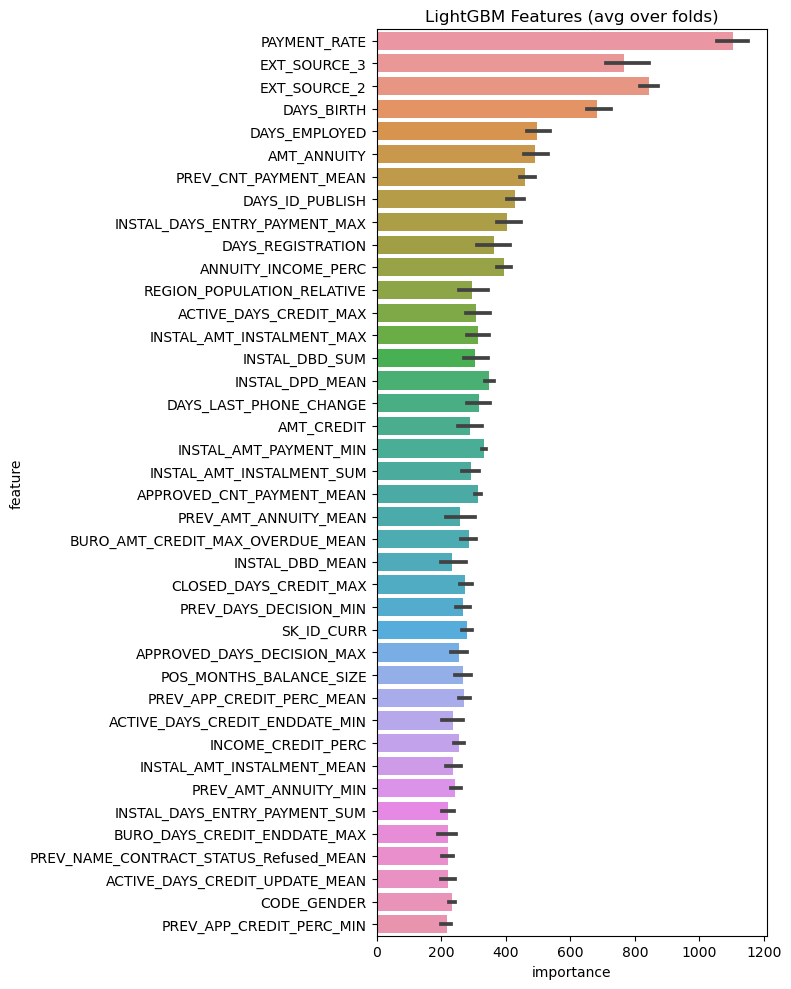

In [15]:
X = data[[c for c in data.columns if c != 'TARGET']]
y = data['TARGET']

target_0 = y[y==0].sample(40000).index
target_1 = y[y==1].index

sample = list(set(list(target_0)+list(target_1)))

X_sample = X.loc[sample]
X_scaled_sample = pd.DataFrame(StandardScaler().fit_transform(X_sample), index=X_sample.index, columns=X_sample.columns)

y_sample = y.loc[sample]

folds = KFold(n_splits=5, shuffle=True, random_state=1001)

oof_preds = np.zeros(X_scaled_sample.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_scaled_sample, y_sample)):
    train_x, train_y = X_scaled_sample.iloc[train_idx], y_sample.iloc[train_idx]
    valid_x, valid_y = X_scaled_sample.iloc[valid_idx], y_sample.iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775)

    clf.fit(train_x.values, train_y.values, eval_set=[(train_x.values, train_y.values), (valid_x.values, valid_y.values)], eval_metric= 'auc', callbacks=[log_evaluation(), early_stopping(stopping_rounds=200)])

    oof_preds[valid_idx] = clf.predict_proba(valid_x.values, num_iteration=clf.best_iteration_)[:, 1]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_scaled_sample.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y.values, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y_sample, oof_preds))

cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

best_features = feature_importance_df.groupby('feature').mean().sort_values(by='importance', ascending=False).head(50).index.values

In [96]:
data_filtered_all_customers = data.copy()
data_filtered_all_customers = data_filtered_all_customers[best_features.tolist() + ['TARGET']]
data_filtered_all_customers.shape

(307507, 51)

Je vais maintenant supprimer les **modalités correspondantes à des outliers**. Un peu plus de **27000 clients** ne seront **pas pris en compte dans la suite de l'étude** car ils seront considérés comme trop éloignés de la masse.

In [97]:
outlier_threshold = 5
minmax = MinMaxScaler()

index_outliers = []

for c in data_filtered_all_customers.columns:
    if c not in ['SK_ID_CURR', 'TARGET'] and len(data_filtered_all_customers[c].unique()) > 30:
        mask_outliers = np.abs(scipy_stats.zscore(data_filtered_all_customers[c])) > outlier_threshold
        index_outliers.extend(data_filtered_all_customers[c].loc[mask_outliers].index.values.tolist())

index_outliers = list(set(index_outliers))
print(f"Pourcentage des outliers avec TARGET = 1 : {100 * data['TARGET'].loc[index_outliers].sum() / len(index_outliers)}%")

index_without_outliers = [i for i in data_filtered_all_customers.index if i not in index_outliers]

data_filtered = data_filtered_all_customers.loc[index_without_outliers]

Pourcentage des outliers avec TARGET = 1 : 6.808014005057382%


In [98]:
# Je sauvegarde ici les données nettoyées, filtrées, imputées et préparées pour la 
# suite du projet ! De la modélisation à la visualisation via le dashboard
save(data_filtered, 'data_filtered', filepath='./data')
save(data_filtered_all_customers, 'data_filtered_all_customers', filepath='./data')

# 3. Ultime préparation avant modélisation

Dans le cadre du travail de modélisation, il est obligatoire de séparer les données en un **jeu d'entraînement** et un **jeu de test**. J'ai donc séparé les données avec **80% pour le jeu d'entrainement**. Comme les données dont je dispose sont très déséquilibrées, j'ai veillé à ce que la **proportion des classes à prédire soit la même** dans les 2 jeux de données en réalisant une **stratification sur la feature cible `TARGET`**. 

In [19]:
data_filtered = load('data_filtered', filepath='./data')

In [20]:
data_final = data_filtered.copy()

In [21]:
X = data_final[[c for c in data_final.columns if c not in ['TARGET', 'SK_ID_CURR']]]
y = data_final['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y, random_state=42)

In [22]:
y_train.value_counts(normalize=True)

0.0    0.917859
1.0    0.082141
Name: TARGET, dtype: float64

In [23]:
y_test.value_counts(normalize=True)

0.0    0.917861
1.0    0.082139
Name: TARGET, dtype: float64

Je vais **normaliser les données** avec un `StandardScaler` avant de réaliser, lorsque cela est nécessaire, un **rééchantillonage** avec la méthode **SMOTE** (**S**ynthetic **M**inority **O**versampling **TE**chnique) pour augmenter le nombre de données disponibles. Ces différentes transformations seront utilisées via un pipeline des librairies `sklearn` ou `imblearn`. Les données de test et de validation (dans le GridSearch) ne doivent **en aucun cas être rééchantillonnées** car il est essentiel que ces données soient le plus proche possible des données réelles futures.

In [24]:
def get_pipeline(classification_model, is_smote=True):
    
    if is_smote:
        pipeline = ImbPipeline([
            ('scaling', StandardScaler()),
            ('sampling', SMOTE(n_jobs=-1, random_state=42)),
            ('classification', classification_model)
        ])
    else:
        pipeline = SkPipeline([
            ('scaling', StandardScaler()),
            ('classification', classification_model)
        ])
        
    return pipeline

# 4. Quelles métriques utiliser ?

Dans cette partie, je vais définir les différents **métriques et indicateurs** sur lesquels je vais baser l'évaluation des modèles testés. C'est ici aussi que je vais notament définir la **fonction coût métier**. Cette fonction devra permettre d'optimiser le bénéfice de la banque.

Je vais maintenant chercher à calculer le score correspondant au résultat de la fonction coût que j'ai imaginée. Cette fonction devrait en théorie être **paramétrée en relation avec les besoins et les attentes de la société financière**.

La fonction coût est basée sur le calcul des indicateurs présents dans une matrice de confusion : les vrais négatifs (TN), les faux positifs (FP), les faux négatifs (FN) et les vrais positifs (TP).

Dans le cas étudié ici, il est utile de donner une **définition métier** à ces indicateurs pour mieux comprendre les résultats et travailler à l'élaboration de notre fonction coût !

* **TN** = Le client *peut rembourser* et la banque *accepte le prêt* (aucun problème dans ce cas)
* **FP** = Le client *peut rembourser* et la banque *n'accepte pas le prêt* (opportunité manquée)
* **FN** = Le client *ne peut pas rembourser* et la banque *accepte le prêt* (grosse erreur)
* **TP** = Le client *ne peut pas rembourser* et la banque *n'accepte pas le prêt* (aucun problème dans ce cas)

La clé du fonctionnement de la fonction coût est de **donner un certain poids à chacun de ces indicateurs** en fonction des attentes de la société financière. Tout dépend si la société "Prêt à dépenser" est plus encline à favoriser l'octroi ou le refus d'un prêt. 

Dans ce cas précis, j'ai fait l'hypothèse que **les faux négatifs étaient beaucoup plus coûteux pour la société que les faux positifs**. J'ai également choisi de **pénaliser tout de même légèrement les faux positifs** puisqu'ils représentent une perte de revenus pour la société. Pour finir, j'ai également décidé de **donner un poids plus important aux vrais positifs par rapport aux vrais négatifs** car même si les deux ne présentent aucun problème, je préfère **mettre en avant une prédiction qui aurait été plus dommageable pour la société si elle avait été mauvaise**.

Avec ces hypothèses, je peux définir un score que j'ai choisi de **normaliser** pour plus de lisibilité. Pour normaliser, je vais chercher à calculer l'**amplitude maximale** entre le *gain le plus important* que pourrait faire la société financière et la *perte maximale* qui pourrait survenir.

* Le gain maximal que pourrait faire la société surviendrait dans le cas suivant : Le prêt est **accordé à tous les clients qui remboursent** et **refusé aux clients qui ne remboursent pas**. Il s'agit bien évidemment du **meilleur cas possible** !

* La perte maximale pour la société correspondrait au cas suivant : Le prêt est **accordé à tous les clients qui ne remboursent pas** et **refusé aux clients qui peuvent rembourser**. Il s'agit bien évidemment du **pire cas possible** !

La fonction ci-dessous **renvoie donc le score normalisé** calculé à partir des classes réelles et celles prédites par le modèle choisi.

In [25]:
def cost_function_score(y_true, y_pred):
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    
    tn_gain = 1
    fp_perte = -2
    fn_perte = -20
    tp_gain = 2
        
    score = (tn * tn_gain + tp * tp_gain) + (fn * fn_perte + fp * fp_perte)
    gain_maximal = ((tn + fp) * tn_gain + (fn + tp) * tp_gain) 
    perte_maximale = ((tp + fn) * fn_perte + (tn + fp) * fp_perte)
    
    norm_score = (score - perte_maximale) / (gain_maximal - perte_maximale)
    
    return norm_score

Ci-dessous, j'ai également créé quelques **fonctions** très utiles pour la suite de l'étape de modélisation.

>La fonction `get_metrics` permet de calculer **différentes métriques** en fonction des données réelles et des résultats fournis par un modèle en termes de prediction et de probabilité.

>La fonction `get_confusion_matrix` permet d'afficher la **matrice de confusion** et de visualiser ainsi facilement les indicateurs utilisés pour calculer la fonction coût.

>La fonction `get_roc_curve` permet d'afficher la **courbe ROC** correspondant dans le cas du projet :
>* à la proportion de **clients ne pouvant pas rembourser et dont la banque n'accepte pas le prêt** parmi tous les **clients ne pouvant pas rembourser quelle que soit la décision de la banque**, 
>* en fonction de la proportion de **clients pouvant rembourser et dont la banque n'accepte pas le prêt** parmi tous les **clients pouvant rembourser quelle que soit la décision de la banque**.
>**Sensibilité en ordonnée et Anti-Spécificité en abscisse*.

>La fonction `get_precision_recall_curve` permet d'afficher la **courbe Precision/Recall** correspondant dans le cas du projet :
>* à la proportion de **clients ne pouvant pas rembourser** parmi tous les **clients dont la banque n'accepte pas le prêt**,
>* en fonction de la proportion de **clients ne pouvant pas rembourser et dont la banque n'accepte pas le prêt** parmi tous les **clients ne pouvant pas rembourser quelle que soit la décision de la banque**. 
>**Precision en ordonnée et Recall en abscisse*.

In [75]:
def get_metrics(y_true, y_predict, y_probability, name, data=None,
                scores=['bal_accuracy','recall_score','precision_score', 'f1_score', 'f2_score', 'f5_score', 'roc_auc_score','cost_function_score']):
       
    score_functions = {'bal_accuracy': (balanced_accuracy_score,{'y_true': y_true, 'y_pred': y_predict}),
                       'recall_score': (recall_score, {'y_true': y_true, 'y_pred': y_predict}),
                       'precision_score': (precision_score, {'y_true': y_true, 'y_pred': y_predict}),
                       'f1_score': (f1_score, {'y_true': y_true, 'y_pred': y_predict}),
                       'f2_score': (fbeta_score, {'y_true': y_true, 'y_pred': y_predict, 'beta': 2}),
                       'f5_score': (fbeta_score, {'y_true': y_true, 'y_pred': y_predict, 'beta': 5}),
                       'roc_auc_score':  (roc_auc_score, {'y_true': y_true, 'y_score': y_probability}),
                       'cost_function_score' : (cost_function_score, {'y_true': y_true, 'y_pred': y_predict})}
                 
    data = pd.DataFrame() if data is None else data
    data[name] = pd.Series([score_functions[score][0](**score_functions[score][1]) for score in scores], index=scores)
    
    return data

def get_confusion_matrix(y_true, y_predict, norm=True, cmap='Blues'):

    fig, ax = plt.subplots(figsize=(5,5))
   
    if norm:
        ConfusionMatrixDisplay.from_predictions(y_true, y_predict, normalize='true', cmap=cmap, ax=ax)
        ax.set_title('Matrice de confusion (Fréquences)')
    else:
        ConfusionMatrixDisplay.from_predictions(y_true, y_predict, cmap=cmap, ax=ax)
        ax.set_title('Matrice de confusion (Nombres)')

    ax.set_xlabel('Classe prédite')
    ax.set_ylabel('Classe réelle')
    ax.grid(False)
    plt.tight_layout(h_pad=0.2, w_pad=0.2)
    
def get_roc_curve(model, X_test, y_test):
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.plot([0, 1], [0, 1], color='k', ls='--', label='Pire résultat')
    RocCurveDisplay.from_estimator(model, X_test, y_test, name='Courbe ROC (Données de test)', c='b', ax=ax)
    ax.set_ylabel("Proportion de clients ne pouvant pas rembourser et\ndont la banque n'accepte pas le prêt parmis\ntous les clients ne pouvant pas rembourser\nquelle que soit la décision de la banque.\n(Sensibilité = TP/(TP+FN))")
    ax.set_xlabel("Proportion de clients pouvant rembourser et\ndont la banque n'accepte pas le prêt parmis\ntous les clients pouvant rembourser\nquelle que soit la décision de la banque.\n(Anti-Spécificité = 1 - TN/(TN+FP))")

def get_precision_recall_curve(model, X_test, y_test): 

    fig, ax = plt.subplots(figsize=(5,5))
    
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name='Courbe Precision/Recall (Données de test)', c='b', ax=ax)
    ax.set_xlabel("Proportion de clients ne pouvant pas rembourser\net dont la banque n'accepte pas le prêt parmis\ntous les clients ne pouvant pas rembourser\nquelle que soit la décision de la banque.\n(Recall = TP/(TP+FN))")
    ax.set_ylabel("Proportion de clients ne pouvant pas rembourser parmis\ntous les clients dont la banque n'accepte pas le prêt.\n(Precision = TP/(TP+FP))")

Je vais maintenant ci-dessous tester les différents indicateurs et métriques sur des **cas particuliers** que j'ai créé moi-même et qui représentent **différentes situations possibles**.

Grâce à ces différents scénarios, j'ai pu montrer que ma fonction coût est **particulièrement liée aux différents f_scores et au recall**. C'est parfaitement logique puisque j'ai choisi de **beaucoup pénaliser les faux négatifs** !

Dans la suite de l'étude, on entrainera donc les différents modèles en cherchant à optimiser le **recall**, le **f1_score**, le  **f2_score**, le **roc_auc_score** (plutôt adapté dans le cas de données déséquilibrées) et le **cost_function_score**. En intégrant ainsi ma fonction coût à l'optimisation du modèle, je réalise ce que l'on appelle du **"Cost-sensitive learning"** qui est très utilisé dans le milieu bancaire lorsque le modèle de score est directement développé par la société !

La méthode d'optimisation utilisée est donc un **mélange de multi-scoring avec du cost-sensitive learning** puisque l'on va utiliser la fonction coût et le roc_auc_score pendant l'entraînement des différents modèles. On calculera ensuite le **seuil de tolérance optimal** permettant de maximiser la fonction coût et ainsi le profit de la banque !

In [27]:
y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Parfait')

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Équilibre', scores)

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Quelques prêts accordés non-remboursés', scores)

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Beaucoup de prêts accordés non-remboursés', scores)

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Quelques prêts non accordés remboursables', scores)

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Beaucoup de prêts non accordés remboursables', scores)

scores.T.sort_values(by='cost_function_score')

,bal_accuracy,recall_score,precision_score,f1_score,f2_score,f5_score,roc_auc_score,cost_function_score
Beaucoup de prêts accordés non-remboursés,0.6,0.2,1.000000,0.333333,0.238095,0.206349,0.6,0.296
Équilibre,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.5,0.500
Quelques prêts accordés non-remboursés,0.9,0.8,1.000000,0.888889,0.833333,0.806202,0.9,0.824
Beaucoup de prêts non accordés remboursables,0.6,1.0,0.555556,0.714286,0.862069,0.970149,0.6,0.904
Quelques prêts non accordés remboursables,0.9,1.0,0.833333,0.909091,0.961538,0.992366,0.9,0.976
Parfait,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000


In [28]:
scores.T.corr().loc[['cost_function_score']]

,bal_accuracy,recall_score,precision_score,f1_score,f2_score,f5_score,roc_auc_score,cost_function_score
cost_function_score,0.722929,0.990736,0.056724,0.948231,0.996827,0.994336,0.722929,1.0


In [29]:
cost_scorer = make_scorer(cost_function_score, greater_is_better=True)
f2_scorer = make_scorer(fbeta_score, greater_is_better=True, beta=2)
recall_scorer = make_scorer(recall_score, greater_is_better=True)
f1_scorer = make_scorer(f1_score, greater_is_better=True)

scorers = {
    'roc_auc': 'roc_auc',
    'cost_scorer': cost_scorer,
    'recall_scorer': recall_scorer,
    'f1_scorer': f1_scorer,
    'f2_scorer': f2_scorer
}

# 5. Modélisation

Dans cette étape, je vais définir **plusieurs fonctions** afin de faciliter le travail de modélisation. Je vais également tester **plusieurs modèles de classification** avec une **apporche systématique** que je vais mettre en place. 

## 5.1 Fonctions génériques pour la modélisation

Dans la fonction ci-dessous, je traite de la **validation croisée** des modèles testés. Je lui donne un **pipeline** qui servira d'estimateur/modèle ainsi qu'une liste de paramètres à optimiser. Ces paramètres peuvent être à la fois ceux du classifieur que je souhaite tester mais également de la méthode d'échantillonage choisie (SMOTE) le cas échéant.

Je donne aussi à cette fonction les métriques que je souhaite utiliser pour trouver le meilleur estimateur. Je passe également une métrique pour faire un `refit` car j'utilise à la base plusieurs métriques (multi-scoring). Par défaut, j'ai choisi d'utiliser la métrique `roc_auc` pour réaliser ce refit car elle est particulièrement bien adaptée aux problèmes utilisant des données déséquilibrées.

Par défaut, j'ai choisi de réaliser la validation croisée sur **10 itérations**. Pour chaque itération, l'échantillon original sera divisé en **5 échantillons** (ou folds). L'apprentissage sera effectué sur 4 de ces échantillons qui auront été augmentés via le pipeline `imblearn`. La validation sera effectuée sur l'échantillon restant.

In [40]:
def get_gridsearch(model_name, estimator, param_grid,
                         X_train, y_train,
                         scoring=scorers,
                         refit_scorer='roc_auc',
                         n_iter=10
                      ):

    gridsearch = GridSearchCV(
                    estimator=estimator,
                    param_grid=param_grid,
                    cv=5, n_jobs=-1,
                    verbose=1,
                    scoring=scoring,
                    refit=refit_scorer,
                    return_train_score=True)

    start = time.time() 
    gridsearch.fit(X_train, y_train)
    end = time.time()
    cv_time = np.round(end - start, 3)
    
    print(f'Recherche du meilleur modèle réalisée en {cv_time} s.')
    
    return gridsearch

La fonction ci-dessous permet de calculer la **probabilité d'appartenance à une classe** en fonction d'un modèle entraîné et d'un jeu de données de test adapté (normalisé en l'occurence). Par défaut, on utilise la méthode `predict_proba` du modèle. Cependant, il peut arriver que le modèle ne dispose pas de cette méthode. Dans ce cas, on utilise une prédiction de probabilité personnalisée calculer à partir de la méthode `decision_function`. 

In [31]:
def get_probability(fitted_model, X_test):
    
    def custom_predict_proba(self, X):
        d = self.decision_function(X)
        d_2d = np.c_[-d, d]
        return softmax(d_2d)

    try:
        y_probability = fitted_model.predict_proba(X_test)
    except AttributeError:
        y_probability = custom_predict_proba(fitted_model, X_test)
    return y_probability

La fonction ci-dessous permet d'**évaluer un modèle issu d'une validation croisée** en :
* récupérant les résultats de la validation, les stockant et les affichant
* récupérant la moyenne de chaque score sur toutes les itérations de la validation croisée
* faisant un fit du meilleur estimateur sur les données d'entraînement (avec le sampling)
* préparant les données de test et récupèrant le meilleur classifieur depuis le pipeline
* calculant la probabilité d'appartenance à la classe `TARGET=1` et en faisant un predict sur les données de test normalisées
* enregistrant et affichant les différents graphiques nécessaires à l'interprétation des résultats

In [43]:
def estimator_evaluation(model_name, gridsearch, X_train, y_train, X_test, y_test, 
                         data_scores=None, data_metrics=None, scorer_names=list(scorers.keys()),
                         score='roc_auc', threshold=None):
    
    print(f"Modèle {model_name} en cours de traitement...\n")
    
    # On récupère ici les résultats de la validation croisée réalisée auparavant
    best_estimator = gridsearch.best_estimator_
    best_params = gridsearch.best_params_
    cross_validation_results = pd.DataFrame(gridsearch.cv_results_)

    
    cross_validation_scores = {
        f'best_cross_validation_score': gridsearch.best_score_, # Meilleur score obtenu pendant la validation croisée
    }
    
    
    # On récupère ici la moyenne des scores sur toutes les itérations de la validation croisée
    for scorer in scorer_names:
        cross_validation_scores[f'mean_val_{scorer}'] = cross_validation_results[f'mean_test_{scorer}'][gridsearch.best_index_].mean()
        cross_validation_scores[f'std_val_{scorer}'] = cross_validation_results[f'std_test_{scorer}'][gridsearch.best_index_].mean()
        cross_validation_scores[f'mean_train_{scorer}'] = cross_validation_results[f'mean_train_{scorer}'][gridsearch.best_index_].mean()
        cross_validation_scores[f'std_train_{scorer}'] = cross_validation_results[f'std_train_{scorer}'][gridsearch.best_index_].mean()

    print(f'Meilleurs paramètres: {best_params}')
    print(f'Meilleur Score (Entraînement) ({score}) : {round(cross_validation_scores[f"mean_train_{score}"], 3)}')
    print(f'Meilleur Score (Validation) ({score}): {round(cross_validation_scores[f"mean_val_{score}"], 3)}')
    
    
    # On fait un fit du meilleur estimateur sur les données d'entraînement (avec le sampling)
    start = time.time()
    best_estimator.fit(X_train, y_train)
    end = time.time()
    best_model_train_time = round(end - start, 3)
    
    print(f"Temps d'entraînement du meilleur estimateur: {best_model_train_time} s\n")
    
    # On prépare les données de test et on récupère le meilleur classifieur depuis le pipeline 
    # (pour ne pas prendre en compte le sampling pour les données de test)
    X_test_scaled = StandardScaler().fit_transform(X_test)
    best_classifier = [step[1] for step in best_estimator.get_params()['steps'] if step[0] == 'classification'][0]
        
    y_probability = get_probability(best_classifier, X_test_scaled)[:,1]
    if threshold is not None:
        y_predict = (y_probability > threshold) * 1
    else:
        y_predict = best_classifier.predict(X_test_scaled)
    
    # On enregistre et on affiche les visualisations des différentes métriques
    data_metrics = get_metrics(y_test, y_predict, y_probability, model_name, data=data_metrics)
    data_scores = pd.DataFrame() if data_scores is None else data_scores
    data_scores[model_name] = pd.Series(cross_validation_scores)
    
    model_cm = get_confusion_matrix(y_test, y_predict, norm=False)
    
    get_roc_curve(best_classifier, X_test_scaled, y_test)
    
    get_precision_recall_curve(best_classifier, X_test_scaled, y_test)
    
    return best_estimator, y_probability, data_metrics, data_scores, model_cm

La fonction ci-dessous permet de mesurer **l'effet d'un seuil de tolérance** sur la décision proposée par le modèle à la société financière. Je vais calculer pour chaque client une prédiction en fonction de ce seuil et de la probabilité d'appartenir à la classe `TARGET=1` *(le client ne rembourse pas le prêt)*. Si cette probabilité est supérieure au seuil de tolérance alors je renvoie une prédiction indiquant que le client **ne remboursera pas le prêt** *(je fais un bypass de la méthode `predict` du modèle)*.

J'obtiendrai le **seuil optimal qui sera le plus bénéfique pour la banque** en cherchant le **seuil qui maximisera le score de la fonction coût** !

In [50]:
def get_best_threshold_for_scorers(y_test, y_probability, plot=False):
    
    def get_threshold_effect_on_scores(y_test, y_probability):
        threshold_effect_on_scores = pd.DataFrame()
        for threshold in [i/20 for i in range(21)]:
            y_predict = (y_probability > threshold) * 1
            threshold_effect_on_scores = get_metrics(y_test, y_predict, y_predict, threshold, data=threshold_effect_on_scores)
        return threshold_effect_on_scores.T
    
    teos = get_threshold_effect_on_scores(y_test, y_probability)
    
    if plot:
        teos[["f1_score", "f2_score", "roc_auc_score", "cost_function_score"]].plot()
        plt.grid()
        plt.xlabel('Threshold')
        plt.ylabel('Score')
    
    for score in ["f1_score", "f2_score", "roc_auc_score", "cost_function_score"]:
        max_score = teos[score].max()
        best_threshold = teos.loc[teos.index[teos[score].argmax()]].name
        print(f'Le seuil optimal pour le "{score}" est de {best_threshold} avec une valeur de {max_score}.')

In [57]:
models = {}

## 5.2 Les différents modèles testés

Les modèles testés seront les suivants :
* un modèle de type **Smote + DummyClassifier** (BaseLine)
* un modèle de type **Smote + GaussianNB**
* un modèle de type **Smote + RidgeClassifier**
* un modèle de type **Smote + LogisticRegression**
* un modèle de type **Smote + RandomForestClassifier**
* un modèle de type **class_weight=balanced + RandomForestClassifier**
* un modèle de type **Smote + LGBM**
* un modèle de type **class_weight=balanced + LGBM**

### 5.2.1 Modèle BaseLine

In [76]:
from sklearn.dummy import DummyClassifier
DummyClassifier().get_params()

{'constant': None, 'random_state': None, 'strategy': 'prior'}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Recherche du meilleur modèle réalisée en 15.916 s.
Modèle Smote+DummyClassifier en cours de traitement...

Meilleurs paramètres: {'classification__strategy': 'stratified', 'sampling__k_neighbors': 5}
Meilleur Score (Entraînement) (roc_auc) : 0.5
Meilleur Score (Validation) (roc_auc): 0.501
Temps d'entraînement du meilleur estimateur: 0.58 s

Le seuil optimal pour le "f1_score" est de 0.0 avec une valeur de 0.14379894147141664.
Le seuil optimal pour le "f2_score" est de 0.0 avec une valeur de 0.25280776597597077.
Le seuil optimal pour le "roc_auc_score" est de 0.0 avec une valeur de 0.505092847829321.
Le seuil optimal pour le "cost_function_score" est de 1.0 avec une valeur de 0.6037708932689793.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


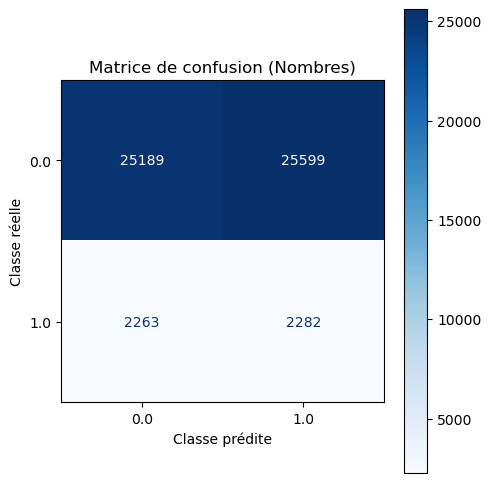

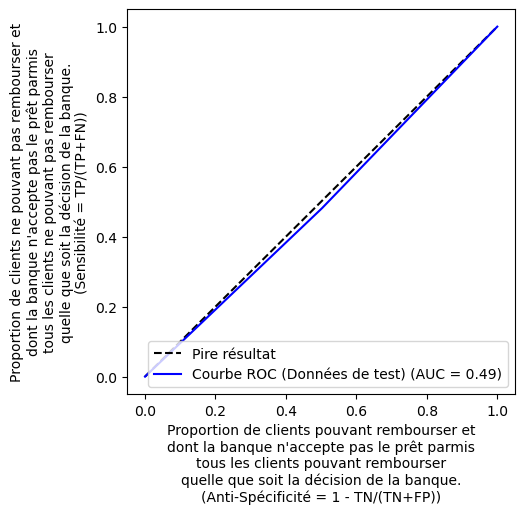

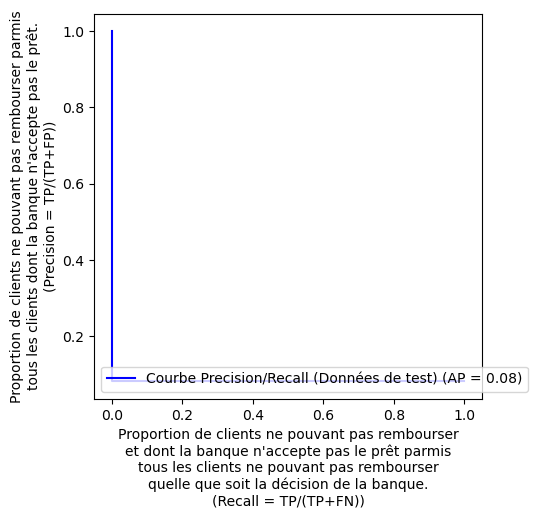

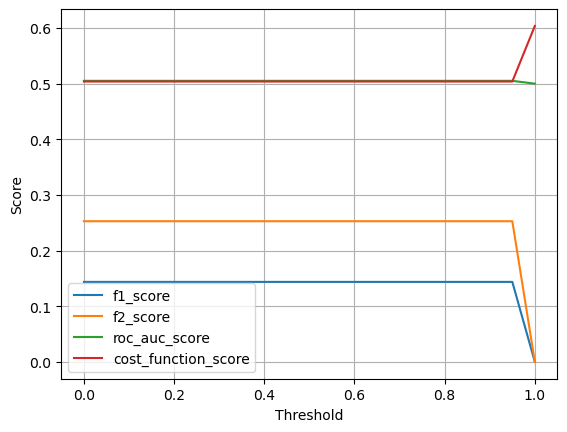

In [77]:
gridsearch = get_gridsearch(model_name='Smote+DummyClassifier',
                            estimator=get_pipeline(classification_model=DummyClassifier(), is_smote=True),
                            param_grid={'classification__strategy': ['most_frequent', 'stratified'], 'sampling__k_neighbors': [3, 5, 7, 9]},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='Smote+DummyClassifier',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=None,
                          data_metrics=None,
                          threshold=None)


models['Smote+DummyClassifier'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

### 5.2.2 Classifieur du type "Simple Naive Bayes"

In [78]:
from sklearn.naive_bayes import GaussianNB
GaussianNB().get_params()

{'priors': None, 'var_smoothing': 1e-09}

Fitting 5 folds for each of 124 candidates, totalling 620 fits
Recherche du meilleur modèle réalisée en 273.837 s.
Modèle Smote+GaussianNB en cours de traitement...

Meilleurs paramètres: {'classification__var_smoothing': 100000000000.0, 'sampling__k_neighbors': 3}
Meilleur Score (Entraînement) (roc_auc) : 0.712
Meilleur Score (Validation) (roc_auc): 0.711
Temps d'entraînement du meilleur estimateur: 0.8 s



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision 

Le seuil optimal pour le "f1_score" est de 0.5 avec une valeur de 0.15578691653652613.
Le seuil optimal pour le "f2_score" est de 0.5 avec une valeur de 0.3149512383357889.
Le seuil optimal pour le "roc_auc_score" est de 0.5 avec une valeur de 0.5154192847023539.
Le seuil optimal pour le "cost_function_score" est de 0.55 avec une valeur de 0.6037708932689793.


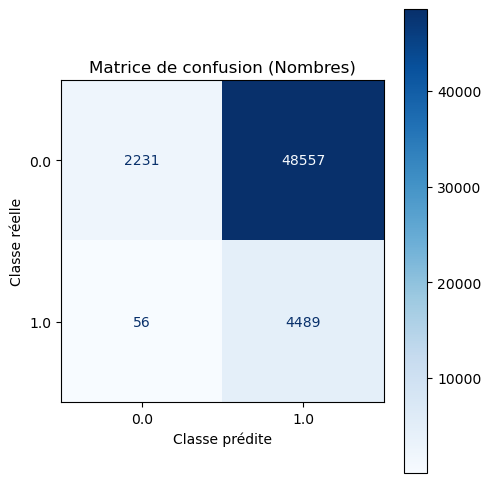

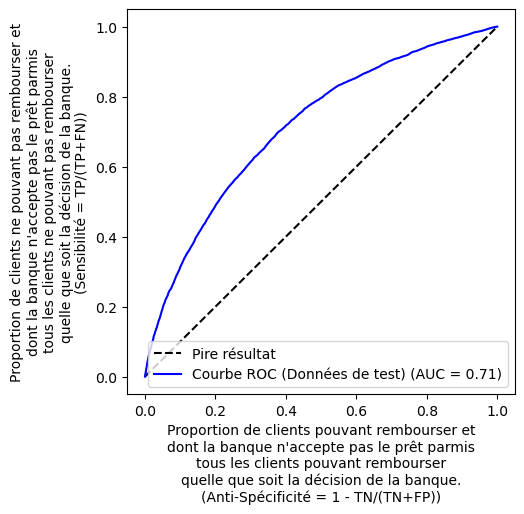

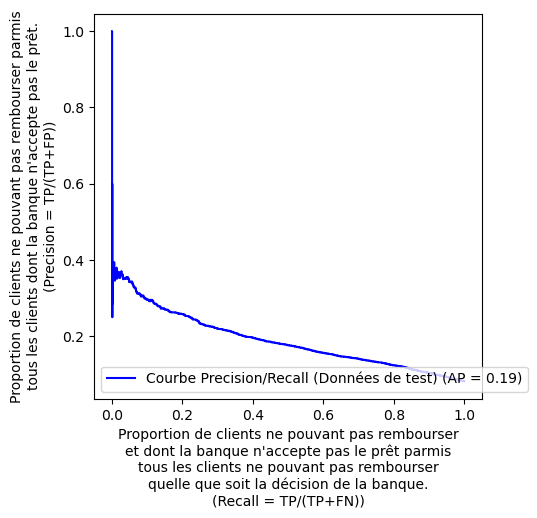

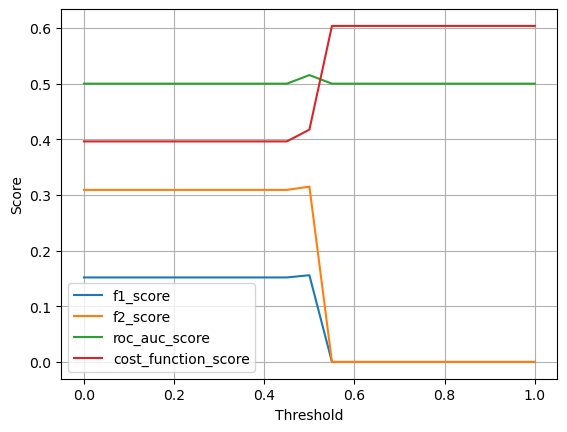

In [79]:
gridsearch = get_gridsearch(model_name='Smote+GaussianNB',
                            estimator=get_pipeline(classification_model=GaussianNB(), is_smote=True),
                            param_grid={'classification__var_smoothing': np.logspace(-15, 15, 31),
                                        'sampling__k_neighbors': [3, 5, 7, 9]},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='Smote+GaussianNB',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=data_scores,
                          data_metrics=data_metrics,
                          threshold=None)


models['Smote+GaussianNB'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

### 5.2.3 Classifieur du type "Ridge"

In [80]:
from sklearn.linear_model import RidgeClassifier
RidgeClassifier().get_params()

{'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Recherche du meilleur modèle réalisée en 129.284 s.
Modèle Smote+RidgeClassifier en cours de traitement...

Meilleurs paramètres: {'classification__alpha': 1000.0, 'sampling__k_neighbors': 3}
Meilleur Score (Entraînement) (roc_auc) : 0.742
Meilleur Score (Validation) (roc_auc): 0.741
Temps d'entraînement du meilleur estimateur: 0.807 s



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le seuil optimal pour le "f1_score" est de 0.65 avec une valeur de 0.290138958647246.
Le seuil optimal pour le "f2_score" est de 0.5 avec une valeur de 0.41411250033755503.
Le seuil optimal pour le "roc_auc_score" est de 0.5 avec une valeur de 0.682012703121143.
Le seuil optimal pour le "cost_function_score" est de 0.6 avec une valeur de 0.6954793662870412.


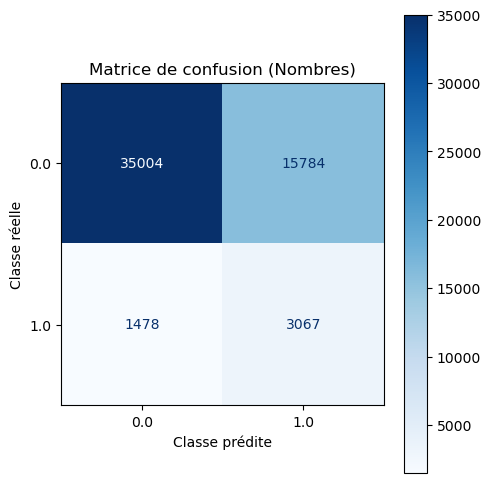

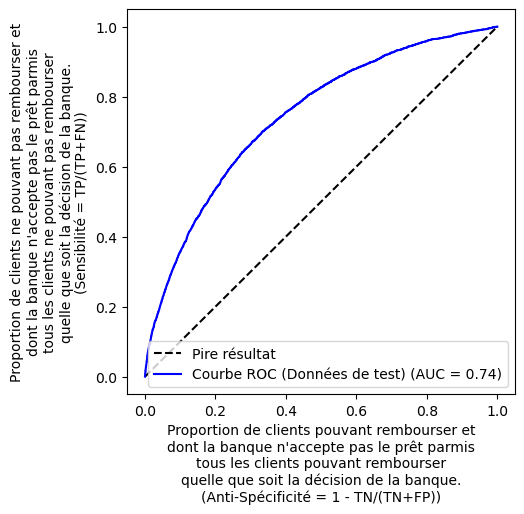

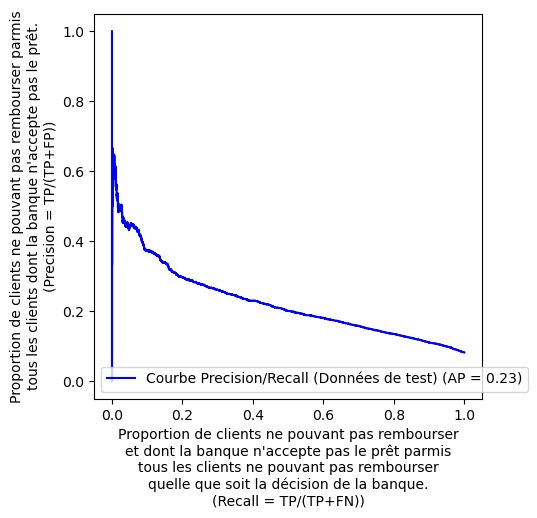

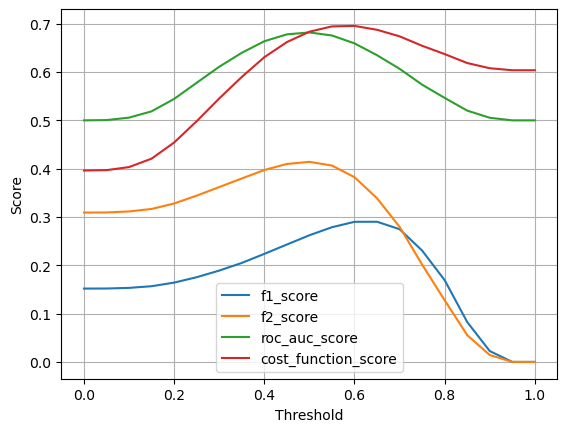

In [81]:
gridsearch = get_gridsearch(model_name='Smote+RidgeClassifier',
                            estimator=get_pipeline(classification_model=RidgeClassifier(), is_smote=True),
                            param_grid={'classification__alpha': np.logspace(-3, 3, 20),
                                        'sampling__k_neighbors': [3, 5, 7, 9]},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='Smote+RidgeClassifier',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=data_scores,
                          data_metrics=data_metrics,
                          threshold=None)


models['Smote+RidgeClassifier'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

### 5.2.4 Classifieur du type "Logistic Regression" avec SMOTE

In [82]:
from sklearn.linear_model import LogisticRegression
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Recherche du meilleur modèle réalisée en 236.758 s.
Modèle Smote+LogisticRegression en cours de traitement...

Meilleurs paramètres: {'classification__l1_ratio': 0.6, 'classification__penalty': 'l1', 'sampling__k_neighbors': 3}
Meilleur Score (Entraînement) (roc_auc) : 0.742
Meilleur Score (Validation) (roc_auc): 0.741


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Temps d'entraînement du meilleur estimateur: 4.307 s

Le seuil optimal pour le "f1_score" est de 0.65 avec une valeur de 0.2915811088295688.
Le seuil optimal pour le "f2_score" est de 0.5 avec une valeur de 0.41406186571405373.
Le seuil optimal pour le "roc_auc_score" est de 0.5 avec une valeur de 0.6819612998158917.
Le seuil optimal pour le "cost_function_score" est de 0.6 avec une valeur de 0.6947423064425371.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


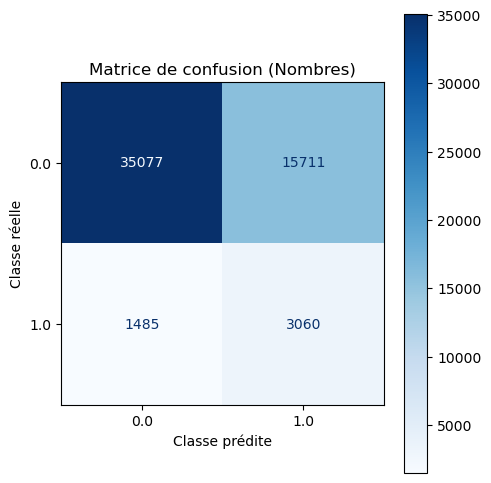

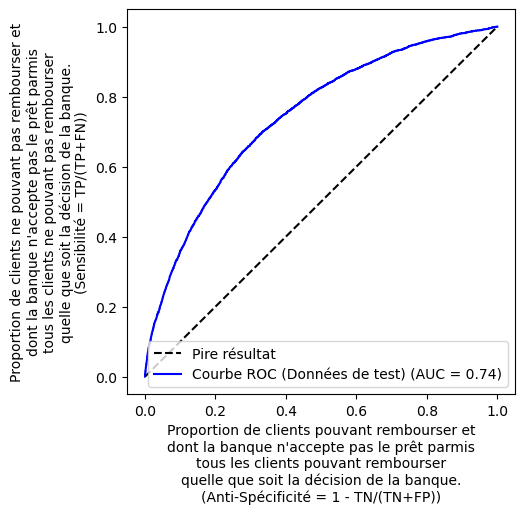

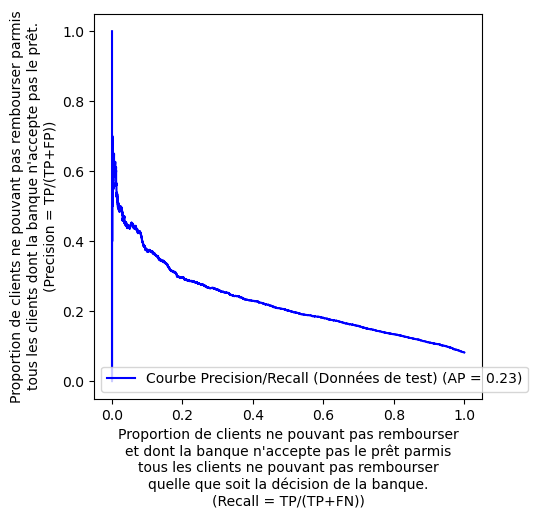

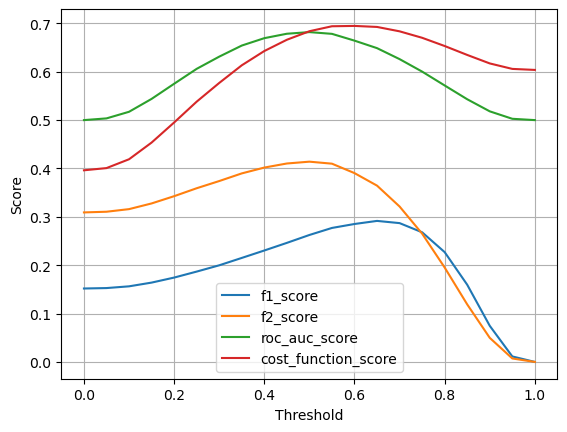

In [83]:
gridsearch = get_gridsearch(model_name='Smote+LogisticRegression',
                            estimator=get_pipeline(classification_model=LogisticRegression(solver='saga'), is_smote=True),
                            param_grid={'classification__penalty': ['elasticnet', 'l1', 'l2'],
                                        'classification__l1_ratio': [0,0.2,0.4,0.6,0.8,1],
                                        'sampling__k_neighbors': [3, 5, 7, 9]},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='Smote+LogisticRegression',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=data_scores,
                          data_metrics=data_metrics,
                          threshold=None)


models['Smote+LogisticRegression'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

### 5.2.5 Classifieur du type "Logistic Regression" avec class_weight = balanced

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Recherche du meilleur modèle réalisée en 40.153 s.
Modèle ClassWeightBalanced+LogisticRegression en cours de traitement...

Meilleurs paramètres: {'classification__l1_ratio': 0.4, 'classification__penalty': 'l1'}
Meilleur Score (Entraînement) (roc_auc) : 0.745
Meilleur Score (Validation) (roc_auc): 0.744


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Temps d'entraînement du meilleur estimateur: 2.533 s

Le seuil optimal pour le "f1_score" est de 0.65 avec une valeur de 0.29287150146899643.
Le seuil optimal pour le "f2_score" est de 0.5 avec une valeur de 0.41628446554794146.
Le seuil optimal pour le "roc_auc_score" est de 0.5 avec une valeur de 0.6839453946182206.
Le seuil optimal pour le "cost_function_score" est de 0.6 avec une valeur de 0.6969138591026891.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


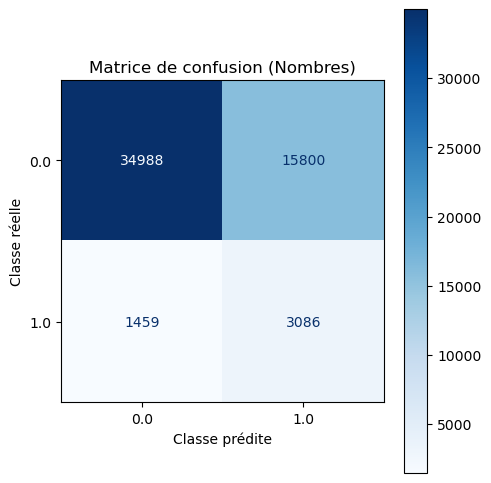

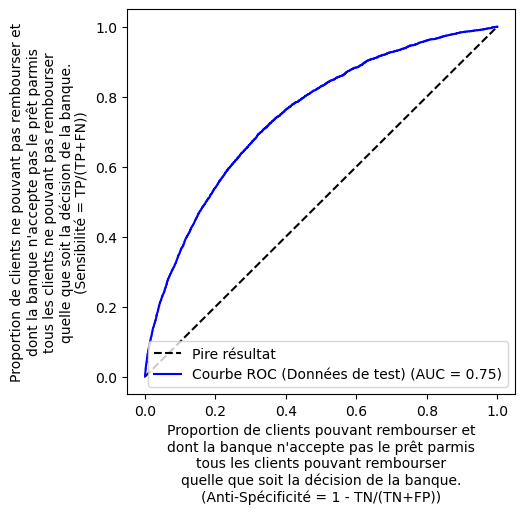

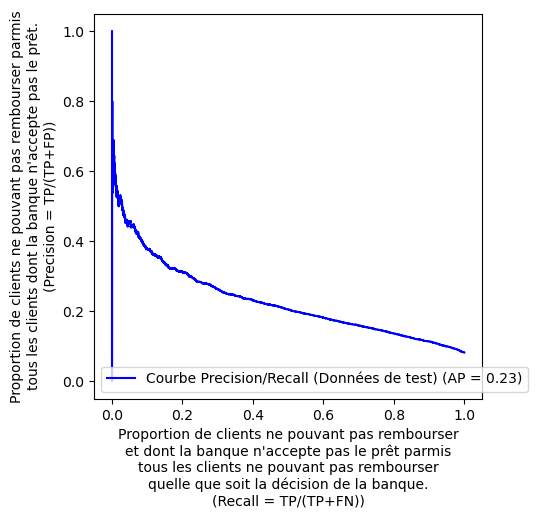

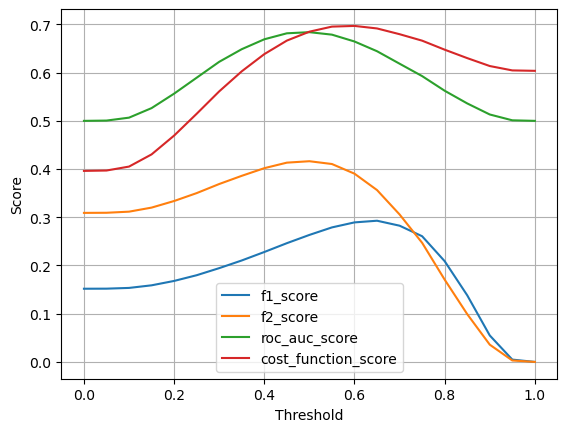

In [84]:
gridsearch = get_gridsearch(model_name='ClassWeightBalanced+LogisticRegression',
                            estimator=get_pipeline(classification_model=LogisticRegression(solver='saga', class_weight='balanced'), is_smote=False),
                            param_grid={'classification__penalty': ['elasticnet', 'l1', 'l2'],
                                        'classification__l1_ratio': [0,0.2,0.4,0.6,0.8,1]},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='ClassWeightBalanced+LogisticRegression',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=data_scores,
                          data_metrics=data_metrics,
                          threshold=None)


models['ClassWeightBalanced+LogisticRegression'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

### 5.2.6 Classifieur du type "Random Forest" avec SMOTE

In [85]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Recherche du meilleur modèle réalisée en 3258.546 s.
Modèle Smote+RandomForestClassifier en cours de traitement...

Meilleurs paramètres: {'classification__criterion': 'gini', 'classification__max_depth': 9, 'sampling__k_neighbors': 3}
Meilleur Score (Entraînement) (roc_auc) : 0.735
Meilleur Score (Validation) (roc_auc): 0.699
Temps d'entraînement du meilleur estimateur: 127.784 s



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le seuil optimal pour le "f1_score" est de 0.75 avec une valeur de 0.2198568710933962.
Le seuil optimal pour le "f2_score" est de 0.7 avec une valeur de 0.36026274801923214.
Le seuil optimal pour le "roc_auc_score" est de 0.7 avec une valeur de 0.625422659025767.
Le seuil optimal pour le "cost_function_score" est de 0.8 avec une valeur de 0.6381313551598152.


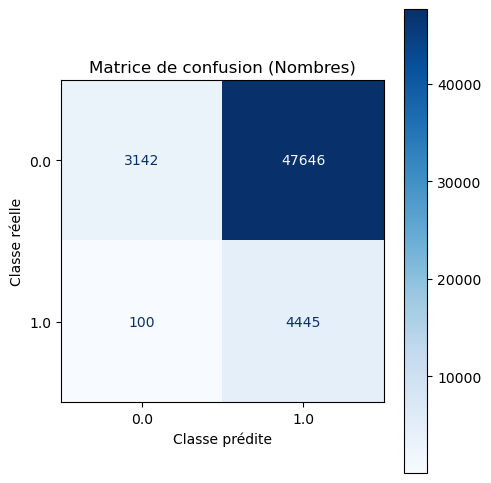

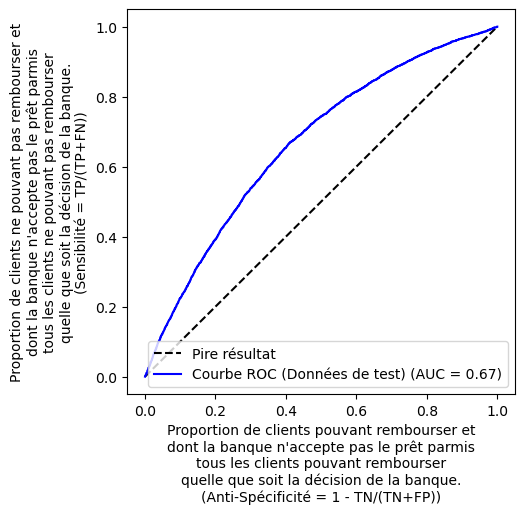

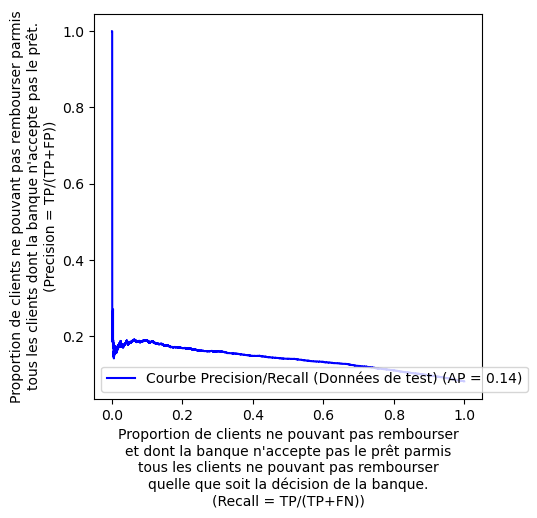

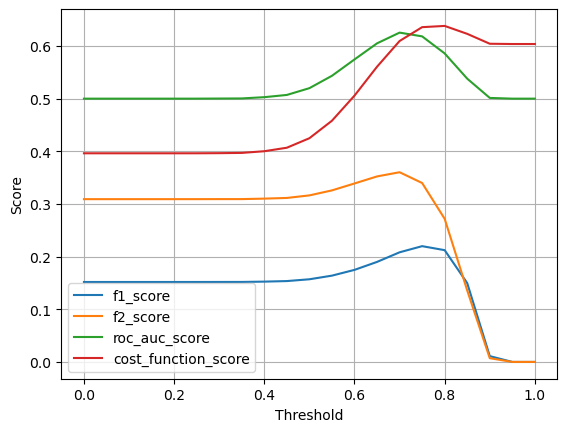

In [86]:
gridsearch = get_gridsearch(model_name='Smote+RandomForestClassifier',
                            estimator=get_pipeline(classification_model=RandomForestClassifier(max_features='auto'), is_smote=True),
                            param_grid={'classification__max_depth': range(3, 10),
                                        'classification__criterion': ['gini', 'entropy'],
                                        'sampling__k_neighbors': [3, 5, 7, 9]},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='Smote+RandomForestClassifier',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=data_scores,
                          data_metrics=data_metrics,
                          threshold=None)


models['Smote+RandomForestClassifier'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

### 5.2.7 Classifieur du type "Random Forest" avec class_weight = balanced

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Recherche du meilleur modèle réalisée en 376.903 s.
Modèle ClassWeightBalanced+RandomForestClassifier en cours de traitement...

Meilleurs paramètres: {'classification__criterion': 'gini', 'classification__max_depth': 9}
Meilleur Score (Entraînement) (roc_auc) : 0.825
Meilleur Score (Validation) (roc_auc): 0.748
Temps d'entraînement du meilleur estimateur: 55.085 s



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le seuil optimal pour le "f1_score" est de 0.6 avec une valeur de 0.29799478464166884.
Le seuil optimal pour le "f2_score" est de 0.45 avec une valeur de 0.42188933047997557.
Le seuil optimal pour le "roc_auc_score" est de 0.45 avec une valeur de 0.689511984198341.
Le seuil optimal pour le "cost_function_score" est de 0.55 avec une valeur de 0.7005040538291448.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


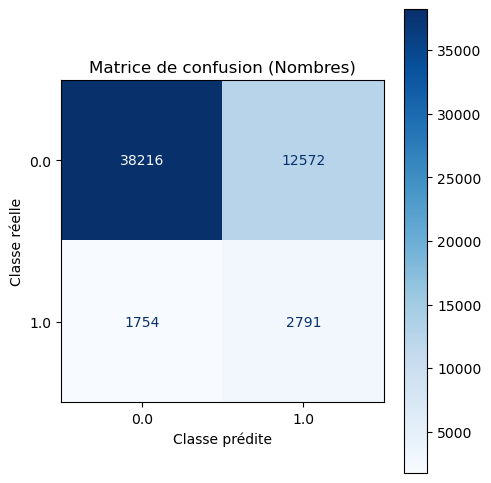

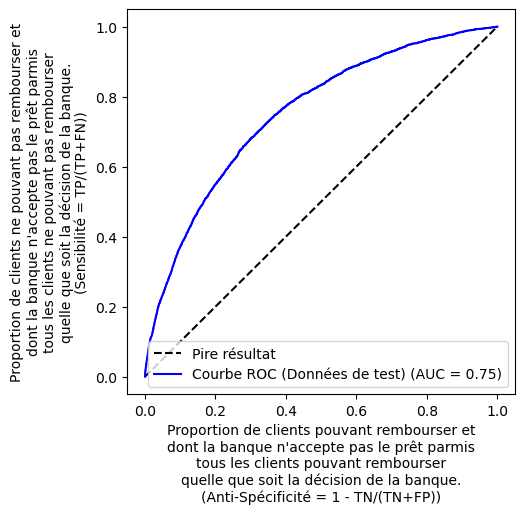

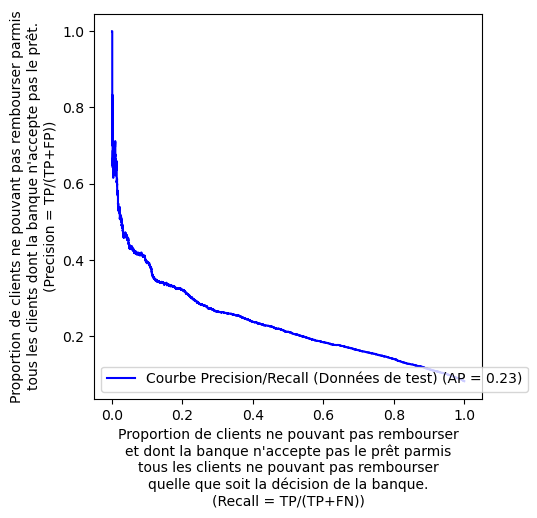

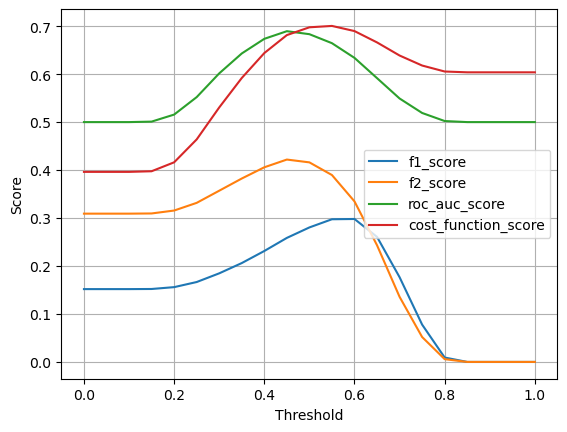

In [87]:
gridsearch = get_gridsearch(model_name='ClassWeightBalanced+RandomForestClassifier',
                            estimator=get_pipeline(classification_model=RandomForestClassifier(max_features='auto', class_weight='balanced'), is_smote=False),
                            param_grid={'classification__max_depth': range(3, 10),
                                        'classification__criterion': ['gini', 'entropy']},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='ClassWeightBalanced+RandomForestClassifier',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=data_scores,
                          data_metrics=data_metrics,
                          threshold=None)


models['ClassWeightBalanced+RandomForestClassifier'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

### 5.2.8 Classifieur du type "LGBM" avec SMOTE

In [88]:
from lightgbm import LGBMClassifier
LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Recherche du meilleur modèle réalisée en 2690.285 s.
Modèle Smote+LGBMClassifier en cours de traitement...

Meilleurs paramètres: {'classification__max_depth': -1, 'classification__min_child_samples': 10, 'classification__reg_alpha': 0.0017782794100389228, 'classification__reg_lambda': 0.5623413251903491, 'sampling__k_neighbors': 7}
Meilleur Score (Entraînement) (roc_auc) : 0.733
Meilleur Score (Validation) (roc_auc): 0.716
Temps d'entraînement du meilleur estimateur: 2.41 s

Le seuil optimal pour le "f1_score" est de 0.95 avec une valeur de 0.1725843141133419.
Le seuil optimal pour le "f2_score" est de 0.9 avec une valeur de 0.3227612848772095.
Le seuil optimal pour le "roc_auc_score" est de 0.95 avec une valeur de 0.5648768044875685.
Le seuil optimal pour le "cost_function_score" est de 1.0 avec une valeur de 0.6037708932689793.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


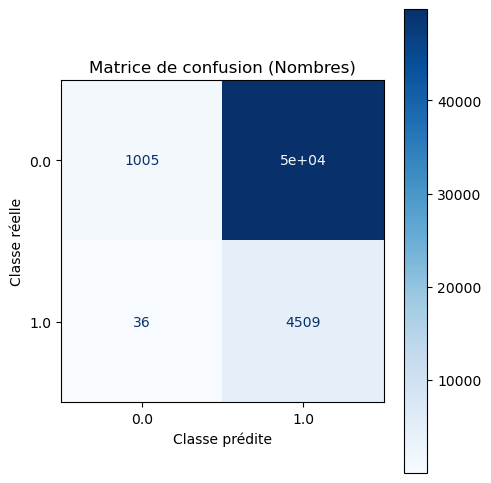

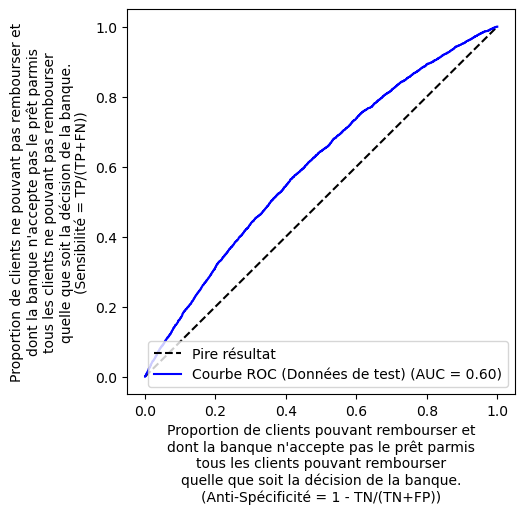

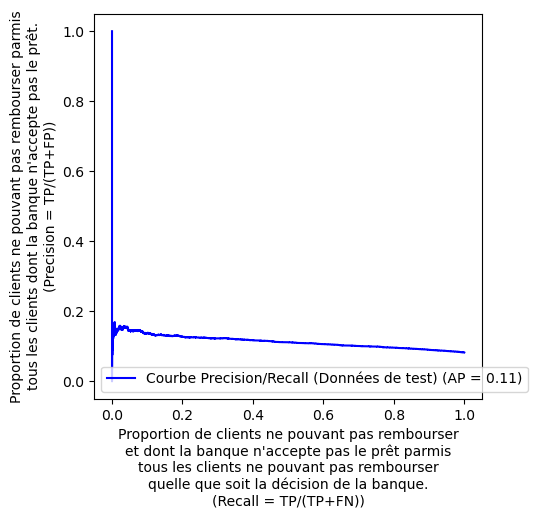

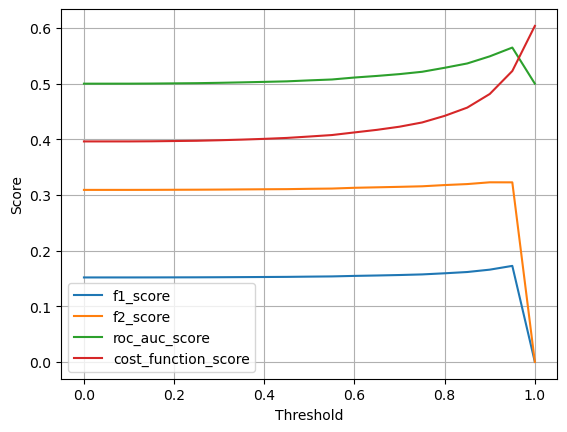

In [89]:
gridsearch = get_gridsearch(model_name='Smote+LGBMClassifier',
                            estimator=get_pipeline(classification_model=LGBMClassifier(), is_smote=True),
                            param_grid={'classification__max_depth': [-1],
                                        'classification__min_child_samples': [10, 20, 30],
                                        'classification__reg_lambda': np.logspace(-4,1,5),
                                        'classification__reg_alpha': np.logspace(-4,1,5),
                                        'sampling__k_neighbors': [3, 5, 7, 9]},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='Smote+LGBMClassifier',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=data_scores,
                          data_metrics=data_metrics,
                          threshold=None)

models['Smote+LGBMClassifier'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

### 5.2.9 Classifieur du type "LGBM" avec class_weight = balanced

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Recherche du meilleur modèle réalisée en 387.026 s.
Modèle ClassWeightBalanced+LGBMClassifier en cours de traitement...

Meilleurs paramètres: {'classification__max_depth': -1, 'classification__min_child_samples': 30, 'classification__reg_alpha': 10.0, 'classification__reg_lambda': 0.0001}
Meilleur Score (Entraînement) (roc_auc) : 0.818
Meilleur Score (Validation) (roc_auc): 0.767
Temps d'entraînement du meilleur estimateur: 1.308 s



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le seuil optimal pour le "f1_score" est de 0.65 avec une valeur de 0.32520200076952677.
Le seuil optimal pour le "f2_score" est de 0.5 avec une valeur de 0.4417179638530512.
Le seuil optimal pour le "roc_auc_score" est de 0.45 avec une valeur de 0.7079102540875494.
Le seuil optimal pour le "cost_function_score" est de 0.55 avec une valeur de 0.7169175047750382.


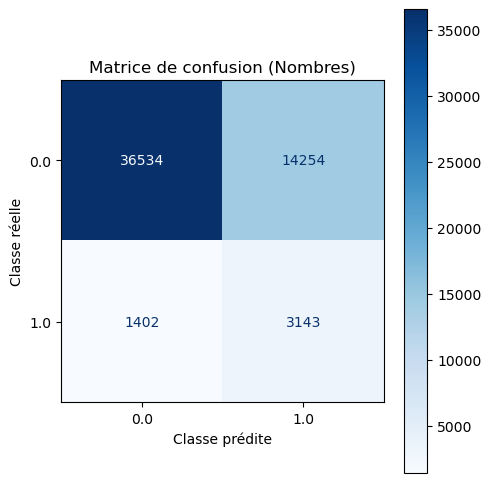

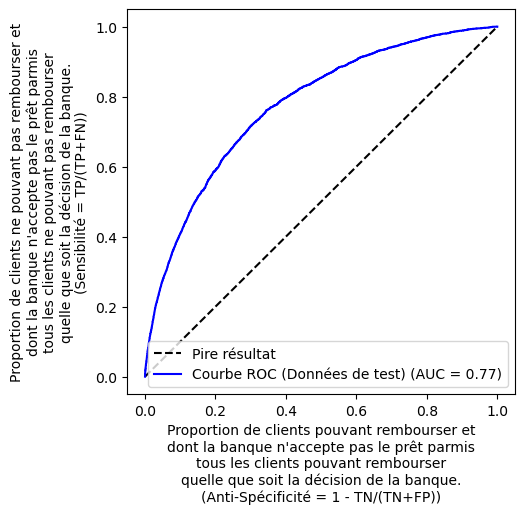

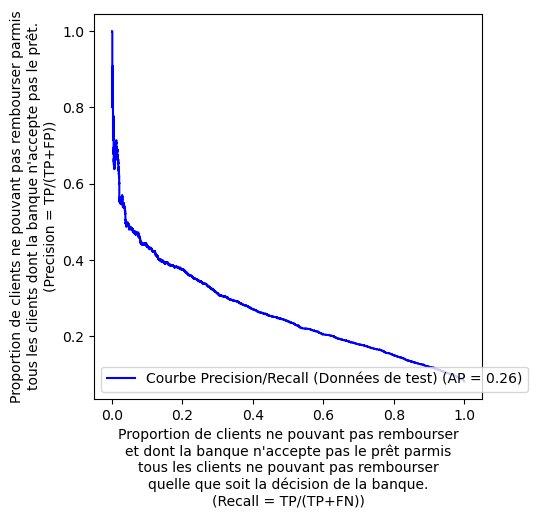

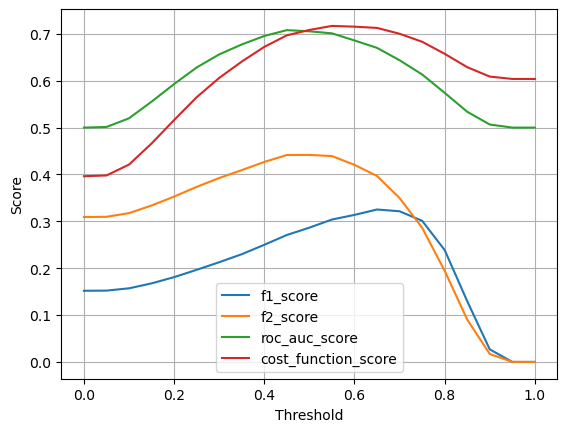

In [90]:
gridsearch = get_gridsearch(model_name='ClassWeightBalanced+LGBMClassifier',
                            estimator=get_pipeline(classification_model=LGBMClassifier(class_weight='balanced'), is_smote=False),
                            param_grid={'classification__max_depth': [-1],
                                        'classification__min_child_samples': [10, 20, 30],
                                        'classification__reg_lambda': np.logspace(-4,1,5),
                                        'classification__reg_alpha': np.logspace(-4,1,5)},
                            X_train=X_train,
                            y_train=y_train)

(best_estimator,
y_probability,
data_metrics,
data_scores,
model_cm) = estimator_evaluation(model_name='ClassWeightBalanced+LGBMClassifier',
                          gridsearch=gridsearch,
                          X_train=X_train,
                          y_train=y_train,
                          X_test=X_test,
                          y_test=y_test, 
                          data_scores=data_scores,
                          data_metrics=data_metrics,
                          threshold=None)

models['ClassWeightBalanced+LGBMClassifier'] = {"estimator": best_estimator, "proba": y_probability}

get_best_threshold_for_scorers(y_test, y_probability, plot=True)

## 5.3 Tableaux de synthèse des résultats

In [91]:
models

{'Smote+DummyClassifier': {'estimator': Pipeline(steps=[('scaling', StandardScaler()),
                  ('sampling', SMOTE(n_jobs=-1, random_state=42)),
                  ('classification', DummyClassifier(strategy='stratified'))]),
  'proba': array([0., 1., 1., ..., 1., 1., 1.])},
 'Smote+GaussianNB': {'estimator': Pipeline(steps=[('scaling', StandardScaler()),
                  ('sampling', SMOTE(k_neighbors=3, n_jobs=-1, random_state=42)),
                  ('classification', GaussianNB(var_smoothing=100000000000.0))]),
  'proba': array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])},
 'Smote+RidgeClassifier': {'estimator': Pipeline(steps=[('scaling', StandardScaler()),
                  ('sampling', SMOTE(k_neighbors=3, n_jobs=-1, random_state=42)),
                  ('classification', RidgeClassifier(alpha=1000.0))]),
  'proba': array([0.56792417, 0.19099036, 0.25149756, ..., 0.43496504, 0.68402144,
         0.2094397 ])},
 'Smote+LogisticRegression': {'estimator': Pipeline(steps=[('scalin

In [92]:
data_scores

,Smote+DummyClassifier,Smote+GaussianNB,Smote+RidgeClassifier,Smote+LogisticRegression,ClassWeightBalanced+LogisticRegression,Smote+RandomForestClassifier,ClassWeightBalanced+RandomForestClassifier,Smote+LGBMClassifier,ClassWeightBalanced+LGBMClassifier
best_cross_validation_score,0.500786,0.711290,0.741212,0.740847,0.744149,0.698604,0.748200,0.716057,0.767367
mean_val_roc_auc,0.500786,0.711290,0.741212,0.740847,0.744149,0.698604,0.748200,0.716057,0.767367
std_val_roc_auc,0.001880,0.005907,0.005430,0.005425,0.005273,0.003002,0.003747,0.004035,0.004450
mean_train_roc_auc,0.500163,0.711641,0.742220,0.741899,0.745090,0.735282,0.825233,0.732986,0.818282
std_train_roc_auc,0.002391,0.001103,0.001353,0.001370,0.001303,0.001493,0.000778,0.000887,0.000630
mean_val_cost_scorer,0.499204,0.415772,0.680713,0.680354,0.681830,0.659322,0.697243,0.626346,0.703391
std_val_cost_scorer,0.002298,0.001972,0.004546,0.004497,0.004437,0.003843,0.004441,0.000906,0.003578
mean_train_cost_scorer,0.499941,0.415856,0.681126,0.680857,0.681649,0.678064,0.749630,0.629218,0.737385
std_train_cost_scorer,0.002332,0.001293,0.001743,0.001626,0.000999,0.000968,0.001375,0.000970,0.000453
mean_val_recall_scorer,0.497415,0.991089,0.666172,0.664246,0.671617,0.437239,0.594224,0.088669,0.675028


In [93]:
data_metrics

,Smote+DummyClassifier,Smote+GaussianNB,Smote+RidgeClassifier,Smote+LogisticRegression,ClassWeightBalanced+LogisticRegression,Smote+RandomForestClassifier,ClassWeightBalanced+RandomForestClassifier,Smote+LGBMClassifier,ClassWeightBalanced+LGBMClassifier
bal_accuracy,0.499027,0.515803,0.682013,0.681961,0.683945,0.519931,0.683271,0.505934,0.705436
recall_score,0.502090,0.987679,0.674807,0.673267,0.678988,0.977998,0.614081,0.992079,0.691529
precision_score,0.081848,0.084625,0.162697,0.163017,0.163401,0.085331,0.181670,0.083051,0.180663
f1_score,0.140751,0.155892,0.262182,0.262481,0.263412,0.156967,0.280390,0.153271,0.286483
f2_score,0.247715,0.315124,0.414113,0.414062,0.416284,0.316276,0.416033,0.311086,0.441718
f5_score,0.419290,0.700266,0.601935,0.600924,0.605504,0.697398,0.562579,0.698166,0.623697
roc_auc_score,0.505093,0.714340,0.743665,0.743162,0.746825,0.665291,0.752181,0.601414,0.773949
cost_function_score,0.498391,0.417869,0.683508,0.683766,0.684974,0.424863,0.697631,0.405038,0.708322


In [95]:
save(models, 'models', filepath='./models')